# New York Rideshare Price Prediction

The goal of this analysis is to
- predict the price or fare
- understand the factors contributing to higher price

## Dataset

The data used was sourced from [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) where monthly High Volumn For-Hire Vehicle Trip Records from January 2024 to December 2024 was downloaded in parquet format.

## Exploratory Data Analysis

In [1]:
# Import Essentials
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load January file to explore
data_path = 'Data'
df = pd.read_parquet(os.path.join(data_path, 'fhvhv_tripdata_2024-01.parquet'))

In [2]:
# Inspect
pd.set_option('display.max_columns', None)
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-01-01 00:21:47,2024-01-01 00:25:06,2024-01-01 00:28:08,2024-01-01 01:05:39,161,158,2.83,2251,45.61,0.0,1.25,4.05,2.75,0.0,0.0,40.18,N,N,N,N,N
1,HV0003,B03404,B03404,2024-01-01 00:10:56,2024-01-01 00:11:08,2024-01-01 00:12:53,2024-01-01 00:20:05,137,79,1.57,432,10.05,0.0,0.28,0.89,2.75,0.0,0.0,6.12,N,N,N,N,N
2,HV0003,B03404,B03404,2024-01-01 00:20:04,2024-01-01 00:21:51,2024-01-01 00:23:05,2024-01-01 00:35:16,79,186,1.98,731,18.07,0.0,0.50,1.60,2.75,0.0,0.0,9.47,N,N,N,N,N
3,HV0003,B03404,B03404,2024-01-01 00:35:46,2024-01-01 00:39:59,2024-01-01 00:41:04,2024-01-01 00:56:34,234,148,1.99,930,17.17,0.0,0.47,1.52,2.75,0.0,0.0,11.35,N,N,N,N,N
4,HV0003,B03404,B03404,2024-01-01 00:48:19,2024-01-01 00:56:23,2024-01-01 00:57:21,2024-01-01 01:10:02,148,97,2.65,761,38.67,0.0,1.06,3.43,2.75,0.0,0.0,28.63,N,N,N,N,N


In [3]:
# Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19663930 entries, 0 to 19663929
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int32         
 8   DOLocationID          int32         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

In [4]:
null_counts = df.isnull().sum()
print(null_counts[null_counts != 0])

originating_base_num    5218737
on_scene_datetime       5218737
dtype: int64


Upon inspection, originating_base_num and on_scene_datetime has some null values.

From data dictionary:
- originating_base_num: base number of the base that received the original trip request
- on_scene_datetime: date/time when driver arrived at the pick-up location (Accessible Vehicles-only)

But still not sure what base is.

In [5]:
print(df['originating_base_num'].unique())
print(df['dispatching_base_num'].unique())

['B03404' None 'B03406' 'B02026' 'B03153' 'B03380' 'B00887']
['B03404' 'B03406']


Googling 'TLC b03404' and 'TLC b03406', base number was small companies affiliated large corporates such as uber/lyft.



In [6]:
uber = df[df['hvfhs_license_num'] == 'HV0003']
lyft = df[df['hvfhs_license_num'] == 'HV0005']
print('uber_ori_base', uber['originating_base_num'].unique())
print('uber_dis_base', uber['dispatching_base_num'].unique())
print('lyft_ori_base', lyft['originating_base_num'].unique())
print('lyft_dis_base', lyft['dispatching_base_num'].unique())

uber_ori_base ['B03404' 'B02026' 'B03153' 'B00887']
uber_dis_base ['B03404']
lyft_ori_base [None 'B03406' 'B03380']
lyft_dis_base ['B03406']


Assumption on the whole dataset
1. Uber and Lyft don't share base
2. There is one dispatching base for each company
3. All null values from originating_base_num is from lyft

In [7]:
# Confirm on_scene_datetime with null values are from lyft as well
print('lyfy_on_sce_date', lyft['on_scene_datetime'].isnull().sum())

lyfy_on_sce_date 5218737


Bingo!
Let's see if we can find some pattern

In [8]:
lyft[lyft['on_scene_datetime'].isnull()].head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
10,HV0005,B03406,None,2024-01-01 00:23:38,NaT,2024-01-01 00:27:59,2024-01-01 00:50:11,88,255,4.272,1332,32.17,0.00,0.88,2.86,2.75,0.0,0.0,27.98,N,N,N,N,N
11,HV0005,B03406,None,2024-01-01 00:42:06,NaT,2024-01-01 00:57:09,2024-01-01 01:14:26,255,79,3.281,1037,42.09,0.00,1.16,3.74,2.75,0.0,0.0,26.09,N,N,N,N,N
13,HV0005,B03406,None,2024-01-01 00:08:37,NaT,2024-01-01 00:11:17,2024-01-01 00:27:44,229,87,5.477,987,22.78,0.00,0.63,2.02,2.75,0.0,0.0,19.10,N,N,N,N,N
14,HV0005,B03406,None,2024-01-01 00:24:53,NaT,2024-01-01 00:32:31,2024-01-01 00:50:13,209,249,2.930,1062,14.53,0.00,0.40,1.29,2.75,0.0,0.0,13.96,N,N,N,N,N
15,HV0005,B03406,None,2024-01-01 00:42:04,NaT,2024-01-01 00:53:16,2024-01-01 01:41:05,249,188,7.643,2869,35.10,0.95,0.99,3.20,2.75,0.0,0.0,41.34,N,N,N,N,N


In [9]:
lyft[lyft['on_scene_datetime'].notnull()].head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
4284,HV0005,B03406,B03406,2024-01-01 01:02:58,2024-01-01 00:55:26,2024-01-01 00:55:28,2024-01-01 01:15:31,42,20,5.350,1203,42.99,0.00,1.18,3.82,0.00,0.0,0.0,36.99,N,N,N,Y,Y
12170,HV0005,B03406,B03406,2024-01-01 01:10:03,2024-01-01 00:58:50,2024-01-01 00:59:50,2024-01-01 02:08:27,79,108,19.106,4117,93.26,1.57,2.46,7.95,2.75,0.0,0.0,88.33,N,N,N,Y,Y
25695,HV0005,B03406,B03406,2024-01-01 00:05:45,2024-01-01 00:09:38,2024-01-01 00:10:38,2024-01-01 00:24:57,42,74,1.625,859,10.43,0.00,0.29,0.93,0.00,0.0,0.0,25.85,N,N,N,Y,Y
28626,HV0005,B03406,B03406,2024-01-01 00:46:34,2024-01-01 00:37:30,2024-01-01 00:38:30,2024-01-01 00:57:15,254,220,6.163,1125,37.62,0.00,1.03,3.34,0.00,0.0,0.0,38.32,N,N,Y,Y,Y
29156,HV0005,B03406,B03406,2024-01-01 00:22:14,2024-01-01 00:11:33,2024-01-01 00:12:33,2024-01-01 00:30:38,61,37,3.070,1085,14.33,0.00,0.39,1.27,0.00,0.0,2.0,30.43,N,N,N,Y,Y


When originating_base_num and on_scene_datetime is None and NaT, wav_request_flag and wav_match_flag are 'N'.

In [10]:
# Investigate
print(lyft[lyft['on_scene_datetime'].notnull()].wav_request_flag.unique())
print(lyft[lyft['on_scene_datetime'].notnull()].wav_match_flag.unique())

print(lyft[lyft['on_scene_datetime'].isnull()].wav_request_flag.unique())
print(lyft[lyft['on_scene_datetime'].isnull()].wav_match_flag.unique())

['Y']
['Y']
['N']
['N' 'Y']


In [11]:
print(lyft[lyft['wav_request_flag'] == 'Y'].on_scene_datetime.notnull().all())
print(lyft[lyft['wav_request_flag'] == 'N'].on_scene_datetime.isnull().all())

True
True


Then the assumption can be restated:
3. Only when Lyft has wav_request_flag 'Y', Lyft records originating_base_num and on_scene_datetime;<br> when Lyft has wav_request_flag 'N', Lyft does not record originating_base_num nor on_scene_datetime.
4. All missing data is due to this data omission from Lyft.

Also the following can be removed,
- dropoff_datetime is pickup_datetime + trip_time
- sales_tax comes after fare
- tips and driver_pay are not interest of this analysis

Let lets pull the data and confirm

In [12]:
# free up some memory
del lyft, uber, df

column_remover = [
    'tips',
    'driver_pay',
    'dropoff_datetime',
    'sales_tax'
]

In [ ]:
# stratified random sampling due to lack of memory
all_files = [f for f in os.listdir(data_path) if f.startswith('fhvhv_tripdata_2024-') and f.endswith('.parquet')]

dfs = []
sampling_rate = 0.02

for file in all_files:
    file_path = os.path.join(data_path, file)
    df_month = pd.read_parquet(file_path)

    filtered_column = df_month.columns.difference(column_remover).tolist()
    df_month_filtered = df_month[filtered_column]

    sampled_df = df_month_filtered.sample(frac=sampling_rate, random_state=42)

    dfs.append(sampled_df)
    # looking for good cheap memory
    del df_month
    del df_month_filtered
    del sampled_df

df = pd.concat(dfs, ignore_index=True)

# save on memory
del dfs
del all_files

In [14]:
# check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4789412 entries, 0 to 4789411
Data columns (total 20 columns):
 #   Column                Dtype         
---  ------                -----         
 0   DOLocationID          int32         
 1   PULocationID          int32         
 2   access_a_ride_flag    object        
 3   airport_fee           float64       
 4   base_passenger_fare   float64       
 5   bcf                   float64       
 6   congestion_surcharge  float64       
 7   dispatching_base_num  object        
 8   hvfhs_license_num     object        
 9   on_scene_datetime     datetime64[us]
 10  originating_base_num  object        
 11  pickup_datetime       datetime64[us]
 12  request_datetime      datetime64[us]
 13  shared_match_flag     object        
 14  shared_request_flag   object        
 15  tolls                 float64       
 16  trip_miles            float64       
 17  trip_time             int64         
 18  wav_match_flag        object        
 19  

Confirm the assumptions
1. Uber and Lyft don't share base.
2. There is one dispatching base for each company.
3. Only when Lyft has wav_request_flag 'Y', Lyft records originating_base_num and on_scene_datetime;<br> when Lyft has wav_request_flag 'N', Lyft does not record originating_base_num nor on_scene_datetime.
4. All missing data is due to this data omission from Lyft.

In [15]:
# Confirm the findings on entire dataset
null_counts = df.isnull().sum()
print('null count:')
print(null_counts[null_counts != 0])
uber = df[df['hvfhs_license_num'] == 'HV0003']
lyft = df[df['hvfhs_license_num'] == 'HV0005']
print('uber_ori_base', uber['originating_base_num'].unique())
print('uber_dis_base', uber['dispatching_base_num'].unique())
print('lyft_ori_base', lyft['originating_base_num'].unique())
print('lyft_dis_base', lyft['dispatching_base_num'].unique())
print(lyft[lyft['wav_request_flag'] == 'Y'].on_scene_datetime.notnull().all())
print(lyft[lyft['wav_request_flag'] == 'N'].on_scene_datetime.isnull().all())

null count:
on_scene_datetime       1203305
originating_base_num    1204515
dtype: int64
uber_ori_base ['B03404' 'B03153' None 'B02026' 'B01312']
uber_dis_base ['B03404']
lyft_ori_base [None 'B03406' 'B03380']
lyft_dis_base ['B03406']
True
True


Assumption 1 and 2 seems right
null count for originating_base_num and on_scene_datetime is different.
Was any assumptions wrong?

In [16]:
lyft[(lyft['originating_base_num'].isnull()) & (lyft['on_scene_datetime'].notnull())]

,DOLocationID,PULocationID,access_a_ride_flag,airport_fee,base_passenger_fare,bcf,congestion_surcharge,dispatching_base_num,hvfhs_license_num,on_scene_datetime,originating_base_num,pickup_datetime,request_datetime,shared_match_flag,shared_request_flag,tolls,trip_miles,trip_time,wav_match_flag,wav_request_flag


Maybe assumption 4 was wrong. "None" was added on uber originating_base_num. Confirm

In [17]:
uber['originating_base_num'].isnull().sum()

1210

All remaining missing data was found. See if there is a pattern.

In [18]:
uber[uber['originating_base_num'].isnull()].sample(10)

,DOLocationID,PULocationID,access_a_ride_flag,airport_fee,base_passenger_fare,bcf,congestion_surcharge,dispatching_base_num,hvfhs_license_num,on_scene_datetime,originating_base_num,pickup_datetime,request_datetime,shared_match_flag,shared_request_flag,tolls,trip_miles,trip_time,wav_match_flag,wav_request_flag
2296695,161,143,N,0.0,15.24,0.42,0.75,B03404,HV0003,2024-06-11 10:45:44,None,2024-06-11 10:45:44,2024-06-11 10:39:43,N,Y,0.00,1.73,1276,N,N
2118624,82,129,N,0.0,5.56,0.16,0.00,B03404,HV0003,2024-06-11 11:04:28,None,2024-06-11 11:05:02,2024-06-11 10:56:24,N,Y,0.00,1.22,577,N,N
2051574,148,79,N,0.0,6.96,0.19,2.75,B03404,HV0003,2024-06-11 20:19:49,None,2024-06-11 20:20:19,2024-06-11 20:18:24,N,N,0.00,0.48,207,Y,N
2286217,232,158,N,0.0,23.93,0.65,2.75,B03404,HV0003,2024-06-11 21:55:51,None,2024-06-11 21:56:11,2024-06-11 21:46:07,N,N,0.00,2.61,1082,N,N
2413002,259,81,N,0.0,7.89,0.22,0.00,B03404,HV0003,2024-06-11 08:51:01,None,2024-06-11 08:53:02,2024-06-11 08:48:57,N,N,0.00,1.52,454,N,N
2232510,132,66,N,2.5,70.94,2.14,0.00,B03404,HV0003,2024-06-11 06:07:13,None,2024-06-11 06:09:13,2024-06-11 06:05:20,N,N,0.00,18.05,2040,N,N
2101747,176,206,N,0.0,22.50,0.62,0.00,B03404,HV0003,2024-06-11 09:55:02,None,2024-06-11 09:55:57,2024-06-11 09:50:32,N,Y,0.00,6.52,1489,N,N
2304492,265,91,N,0.0,110.25,3.97,0.00,B03404,HV0003,2024-06-11 07:16:25,None,2024-06-11 07:18:19,2024-06-11 07:09:18,N,N,26.94,30.62,4994,N,N
2241527,61,61,N,0.0,7.35,0.22,0.00,B03404,HV0003,2024-06-11 13:09:32,None,2024-06-11 13:09:44,2024-06-11 13:07:00,N,N,0.00,0.71,544,N,N
2194514,163,138,N,2.5,113.74,3.39,2.75,B03404,HV0003,2024-06-11 22:13:23,None,2024-06-11 22:14:14,2024-06-11 22:09:26,N,N,6.94,10.06,1592,N,N


Don't really see any clear patterns. Let's keep it for now.


In [19]:
del lyft, uber

## Data Preparation

Before the data is cleaned to produce models, let's think ahead and think of what needs to be done.

This is a price prediction model with more than million rows of data.<br>
It is a supervised regression problem.<br>
It has numerous categorical features <br>
The best option would be <br>

- Linear Regression
    - Lasso regressor can be used as not all features would be important.
    - Not might fit, as features are likely not linear and there are a lot of categorical features.

-  Regression Tree
    - XGBoost Regressor can be used.
    - This will likely fit, and hyperparameter tuning can follow.
    - SHAP analysis can explain the variables as well.

 In order to achieve the above,
 1. Missing data needs to be handled.
 2. Some feature engineering.
 3. Add potentially relevant data.
 4. Categorical features will be encoded right away if binary, and go on pipeline if multiple categories are available.






### Missing data

The missing data from Uber is Missing Completely at Random (MCAR) as the missing value does not depends on any other values.<br>
Since the number of rows with missing data is small, those rows will be removed.

The missing data from Lyft is Missing at Random (MAR) as the missing value depends on values of hvfhs_license_num and wav_request_flag.<br>
- originating_base_num: filled with indicator showing it was missing.
- on_scene_datetime: create binary indicator column showing if it was missing. Then impute with a special constant.

In [20]:
# Remove MCAR rows
rows_to_drop = (df['hvfhs_license_num'] == 'HV0003') & (df['originating_base_num'].isna())
df = df[~rows_to_drop]

In [21]:
# MAR originating_base_num missing value
df['originating_base_num'] = df['originating_base_num'].fillna('Missing')

In [22]:
# MAR on_scene_datetime_missing missing value
df['on_scene_datetime_missing'] = df['on_scene_datetime'].isnull()
df['on_scene_datetime'] = df['on_scene_datetime'].fillna(pd.to_datetime('2023-10-01 00:00:00'))

In [23]:
# Check no missing value
null_counts = df.isnull().sum()
print('null count:')
print(null_counts[null_counts != 0])

null count:
Series([], dtype: int64)


### Data Preprocessing

First of all, remove dispatching_base_num as it perfectly matches hvfhs_license_num

In [24]:
df = df.drop(columns=['dispatching_base_num'])

#### Target Engineering
Before feature engineering begins, plot and observe the features against the targets

The target variables are ones related to the fare. <br>
base_passenger_fare is the most important variable of them all and will be focused on in this analysis.<br>
However, other target features will also be explored for future analysis. <br>
Check their distribution.

In [25]:
target_features = ['tolls', 'airport_fee', 'bcf', 'congestion_surcharge', 'base_passenger_fare']

In [26]:
df[target_features].describe()

,tolls,airport_fee,bcf,congestion_surcharge,base_passenger_fare
count,4.788202e+06,4.788202e+06,4.788202e+06,4.788202e+06,4.788202e+06
mean,1.179479e+00,2.128591e-01,7.450964e-01,1.039250e+00,2.621031e+01
std,4.039538e+00,7.007384e-01,6.833812e-01,1.327337e+00,2.300324e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.628000e+01
25%,0.000000e+00,0.000000e+00,3.400000e-01,0.000000e+00,1.249000e+01
50%,0.000000e+00,0.000000e+00,5.400000e-01,0.000000e+00,1.960000e+01
75%,0.000000e+00,0.000000e+00,8.900000e-01,2.750000e+00,3.137000e+01
max,8.312000e+01,7.250000e+00,2.859000e+01,5.500000e+00,1.027010e+03


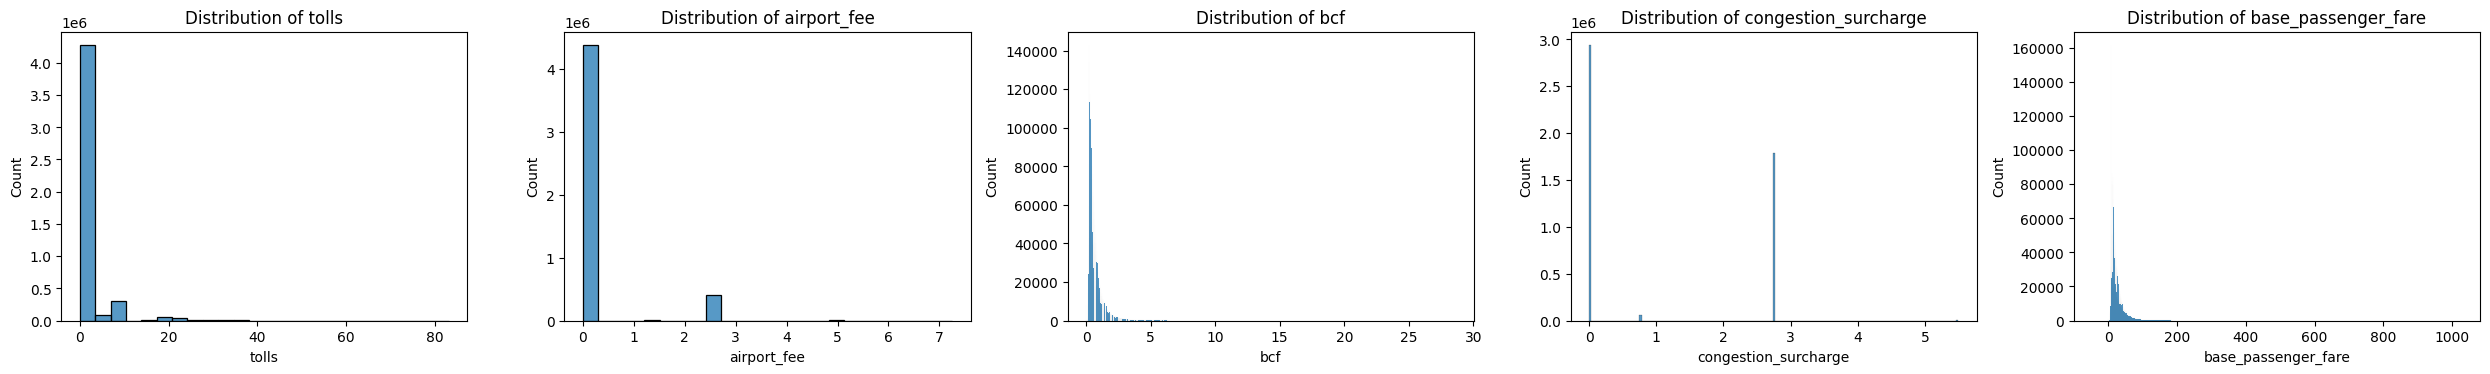

In [27]:
def histogram_plot(features_to_plot):
    num_features = len(features_to_plot)
    num_cols = 5
    num_rows = (num_features + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 4 * num_rows))
    axs = axs.flatten()

    for i, feature in enumerate(features_to_plot):
        ax = axs[i]
        sns.histplot(df[feature], ax=ax)
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of {feature}')

# Remove empty subplots
    for i in range(num_features, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

histogram_plot(target_features)

Who pays 1027 base fare for a ride? <br>
Confirm the outliers and trim them

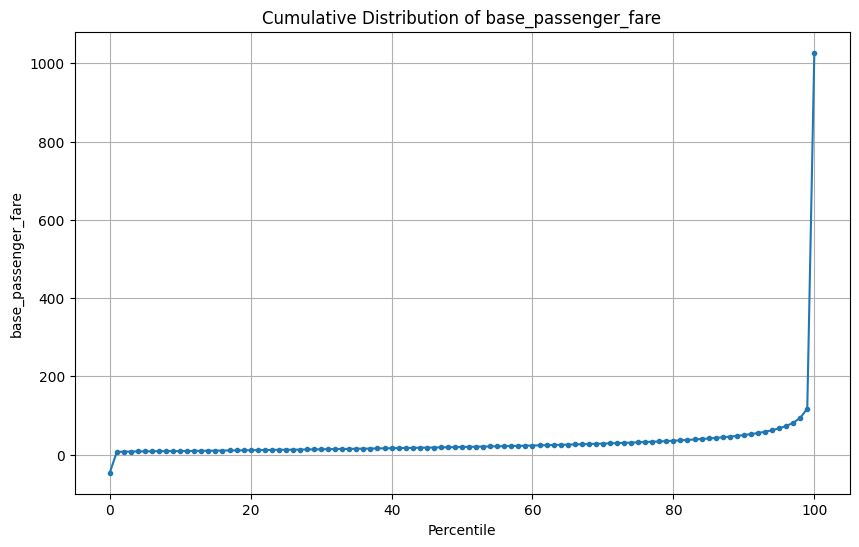

In [28]:
def percentile_grapher(min, max, step, target):
    percentiles = np.arange(min, max+step, step=step)
    valid_percentiles = percentiles[(percentiles >= 0) & (percentiles <= 100)]
    fare_values = np.percentile(df[target], valid_percentiles)

    plt.figure(figsize=(10, 6))
    plt.plot(valid_percentiles, fare_values, marker='.')
    plt.xlabel('Percentile')
    plt.ylabel(target)
    plt.title(f'Cumulative Distribution of {target}')
    plt.grid(True)
    plt.show()

percentile_grapher(0,100,1,"base_passenger_fare")

Even 1% is a lot of data. Rather keep as much of the data as possible.<br>
Go deeper

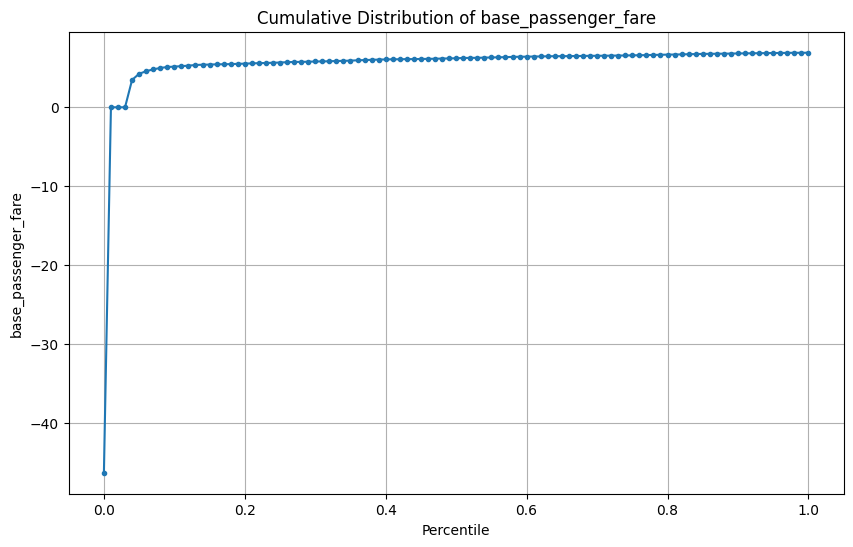

In [29]:
percentile_grapher(0,1,0.01,"base_passenger_fare")

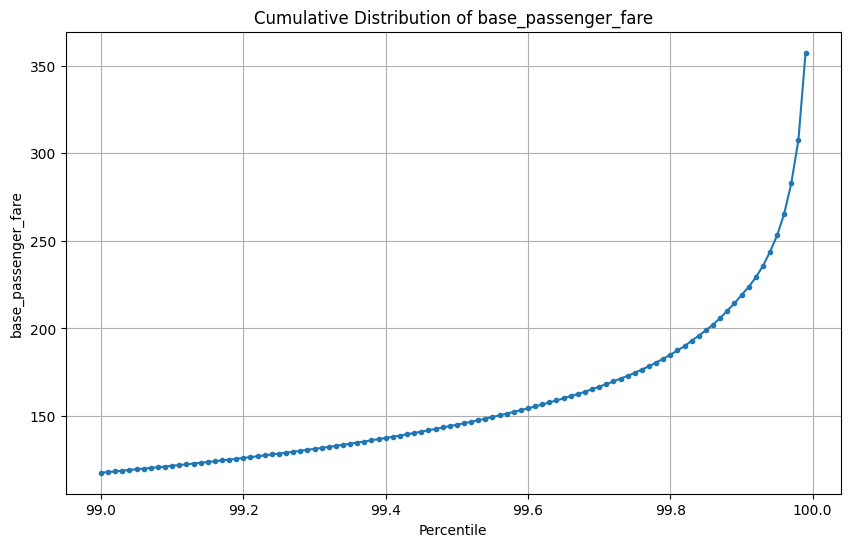

In [30]:
percentile_grapher(99,100,0.01,"base_passenger_fare")

In [31]:
# Fare is 0 when lower than bottom 0.04%. Looks like a good trimming point
# Calculate the bottom 0.04% and top 99.96% percentiles
lower_bound = df['base_passenger_fare'].quantile(0.0004)
upper_bound = df['base_passenger_fare'].quantile(0.9996)

# Trim the DataFrame
df = df[(df['base_passenger_fare'] >= lower_bound) & (df['base_passenger_fare'] <= upper_bound)]

In [32]:
# Check the result
df[target_features].describe()

,tolls,airport_fee,bcf,congestion_surcharge,base_passenger_fare
count,4.784371e+06,4.784371e+06,4.784371e+06,4.784371e+06,4.784371e+06
mean,1.173714e+00,2.126459e-01,7.418361e-01,1.039744e+00,2.609675e+01
std,4.017029e+00,7.004009e-01,6.586954e-01,1.327464e+00,2.208884e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.470000e+00
25%,0.000000e+00,0.000000e+00,3.400000e-01,0.000000e+00,1.249000e+01
50%,0.000000e+00,0.000000e+00,5.400000e-01,0.000000e+00,1.960000e+01
75%,0.000000e+00,0.000000e+00,8.900000e-01,2.750000e+00,3.136000e+01
max,7.503000e+01,6.250000e+00,1.032000e+01,5.500000e+00,2.654500e+02


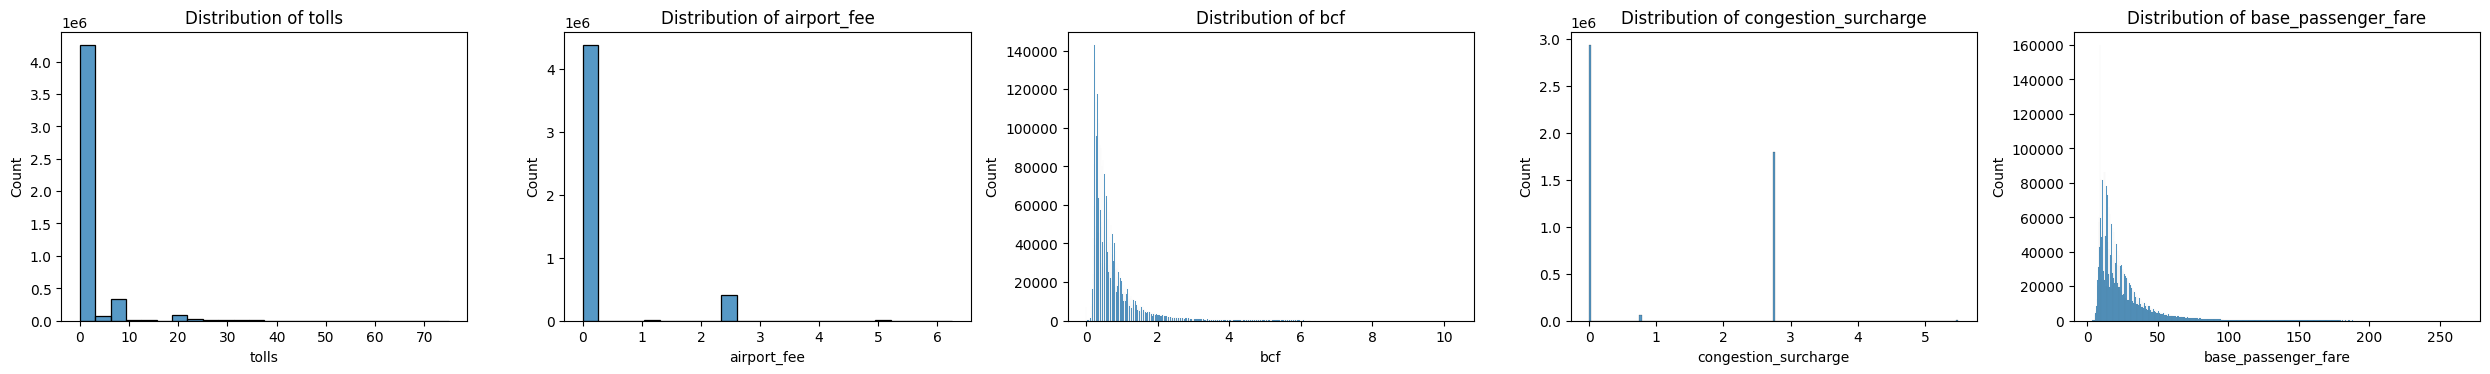

In [33]:
histogram_plot(target_features)

Looks better.<br>

Looking at the distributions, tolls, airport_fee, and congestion_surcharge looks more categorical, where toll has numerous categories.<br>
Classification instead of regression would be needed. <br>

bcf and base_passenger_fare, on the other hand, are continuous, but skewed right.<br>
log transformation can be applied on base_passenger_fare.<br>
bcf has 0 values, so yeo-johnson power transformation can be applied

In [34]:
# Confirm
print(df['tolls'].nunique())
print(df['airport_fee'].nunique())
print(df['congestion_surcharge'].nunique())

3833
10
4


Nevermind. toll is continuous, and skewed right.

Apply transformation on tolls, base_passenger_fare, and bcf.

In [35]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df['bcf_log'] = np.log(df['bcf']+1)
df['bcf_trans'] = pt.fit_transform(df[['bcf']])
df['base_passenger_fare_log'] = np.log(df['base_passenger_fare'])
df['base_passenger_fare_trans'] = pt.fit_transform(df[['base_passenger_fare']])
df['tolls_log'] = np.log(df['tolls']+1)
df['tolls_trans'] = pt.fit_transform(df[['tolls']])

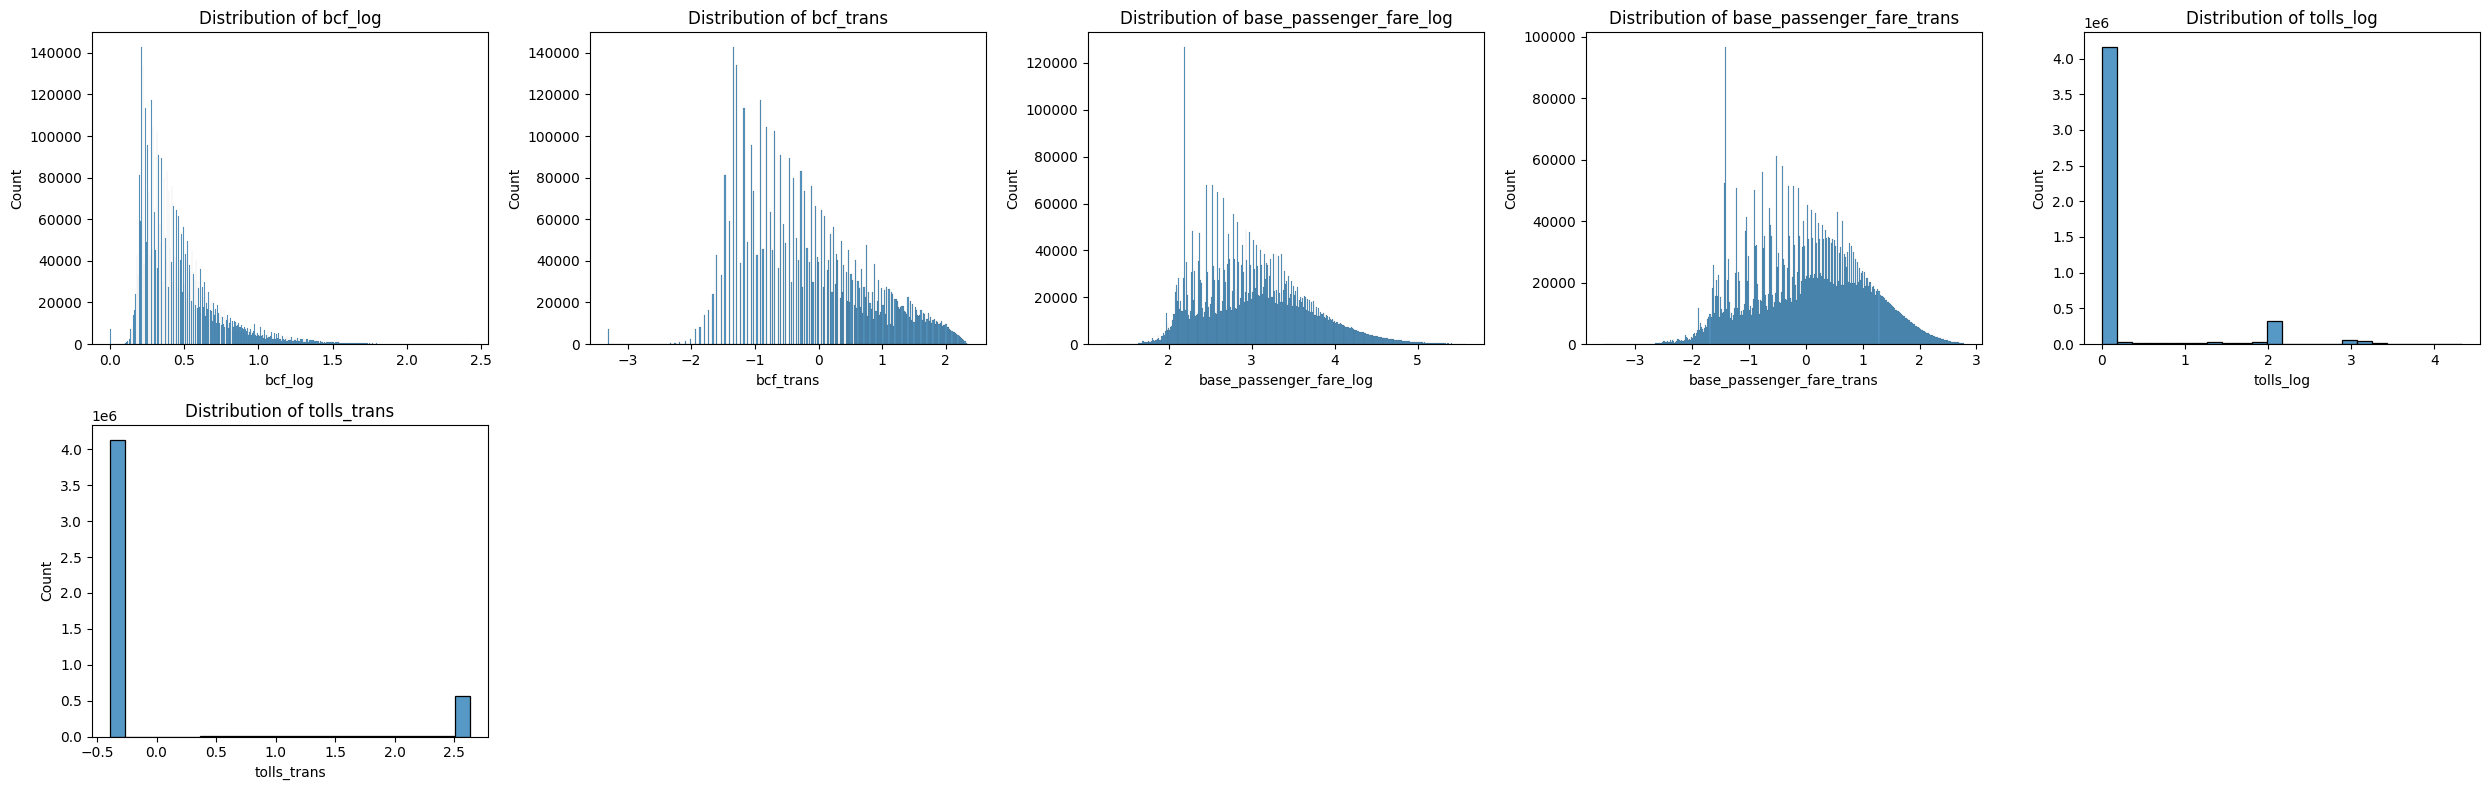

In [36]:
histogram_plot(['bcf_log', 'bcf_trans', 'base_passenger_fare_log', 'base_passenger_fare_trans', 'tolls_log', 'tolls_trans'])

Power transformation was more effective for bcf. Drop bcf_log. <br>
Log transformation was more effective for base_passenger_fare. Drop base_passenger_trans. <br>
Neither power nor log transformation were effective for tolls. Drop both and use original tolls.



In [37]:
df = df.drop(columns=['bcf_log', 'base_passenger_fare_trans', 'tolls_log', 'tolls_trans'])

#### Feature Engineering

Now, lets look at the features.

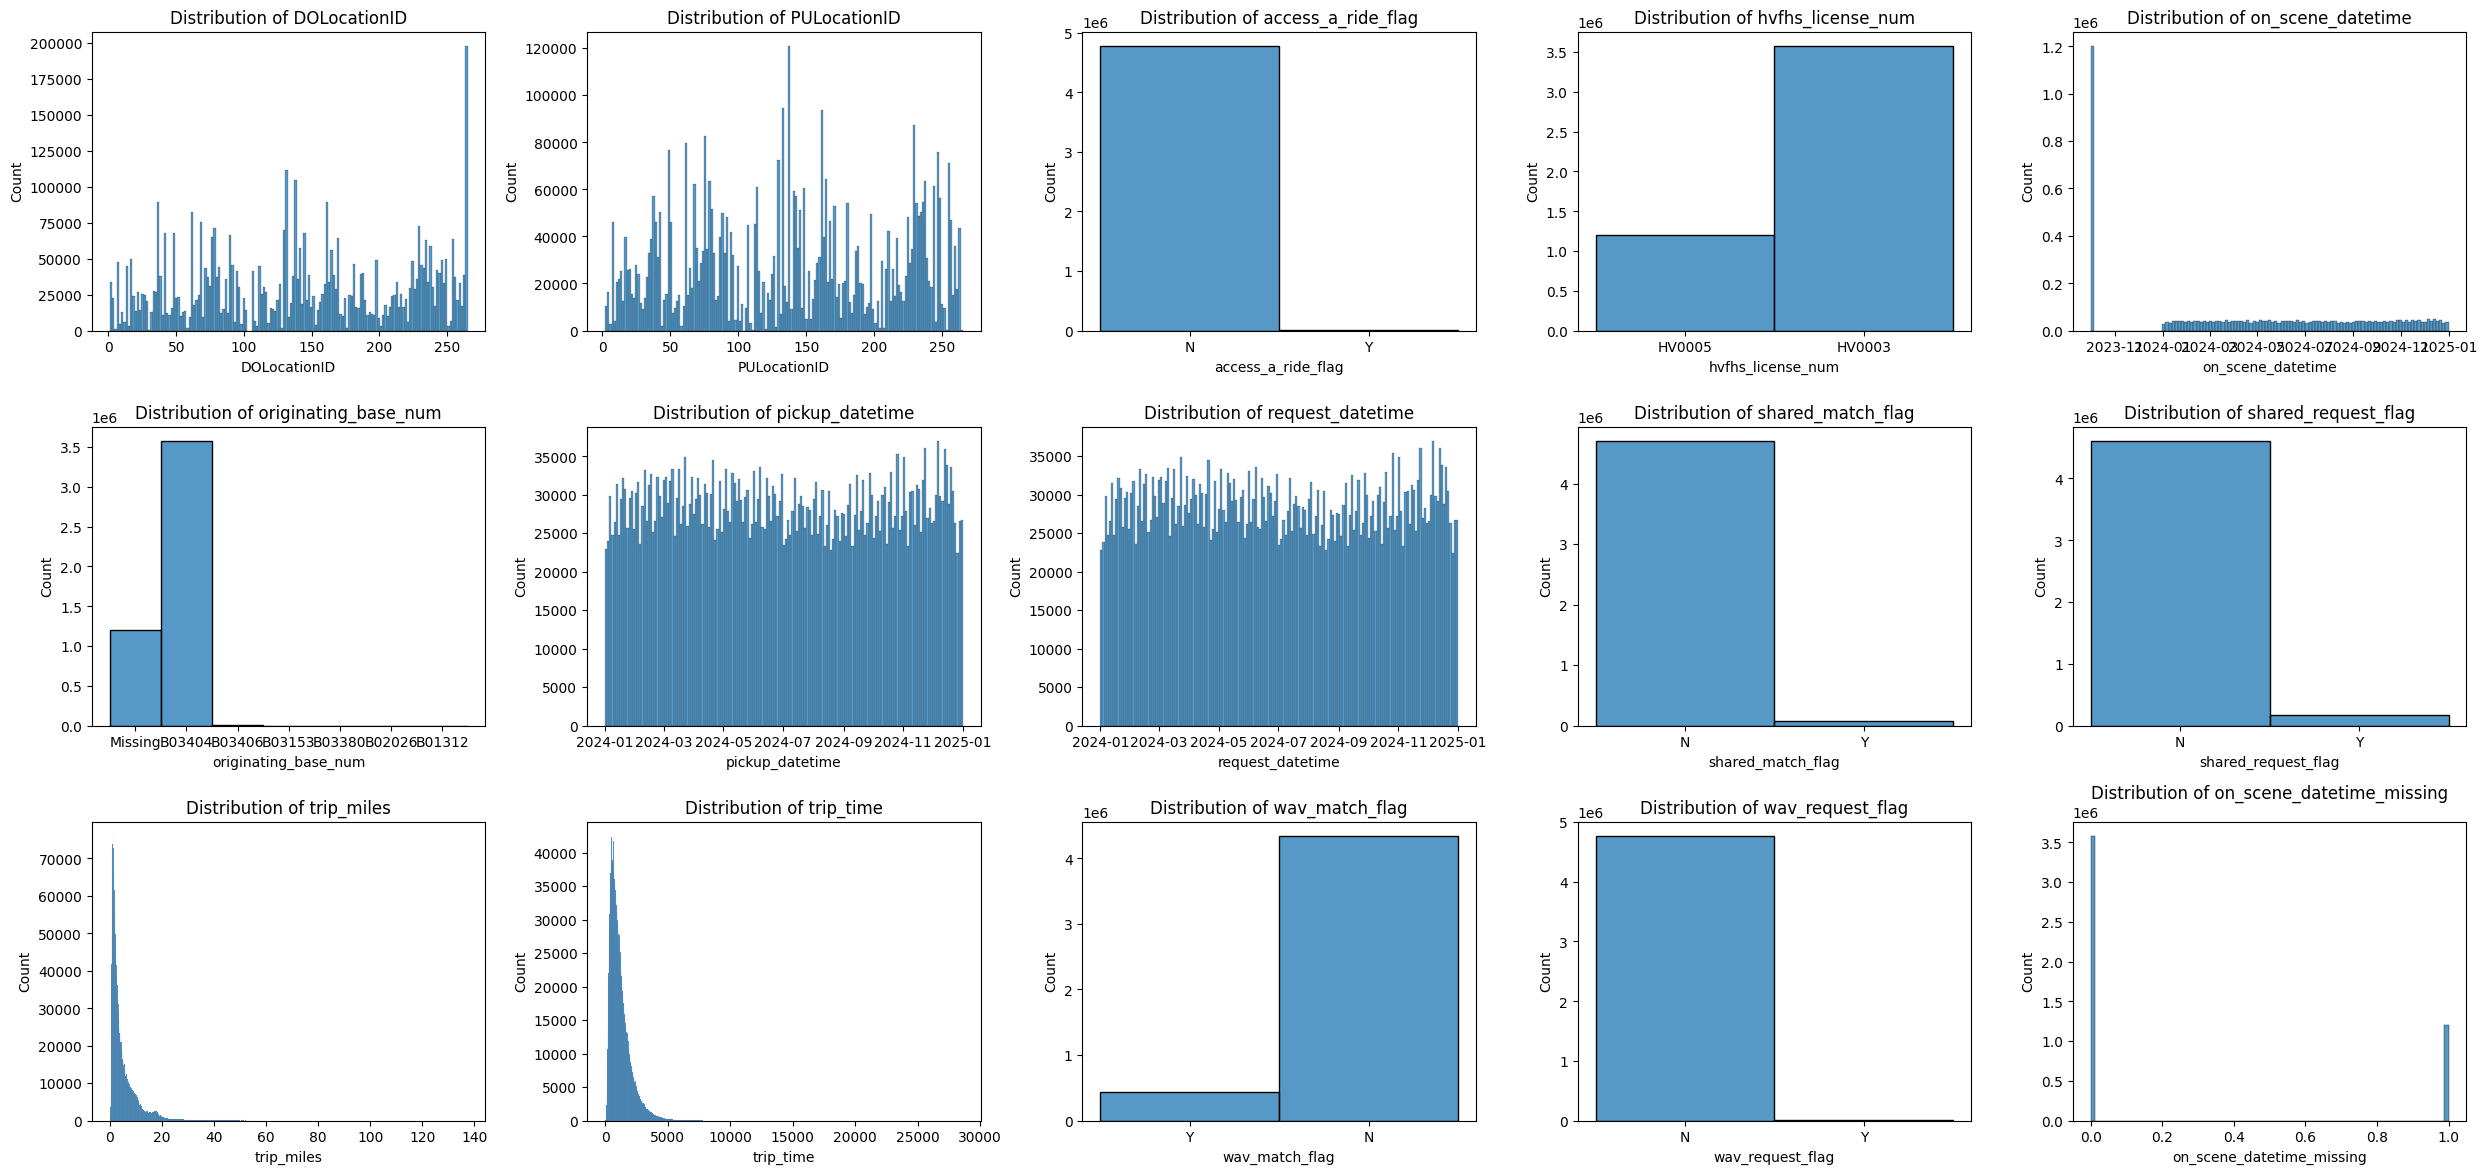

In [38]:
target_features.extend(['bcf_trans', 'base_passenger_fare_log'])

features_to_plot = [col for col in df.columns if col not in target_features]

histogram_plot(features_to_plot)

In [39]:
df[features_to_plot].describe()

,DOLocationID,PULocationID,on_scene_datetime,pickup_datetime,request_datetime,trip_miles,trip_time
count,4.784371e+06,4.784371e+06,4784371,4784371,4784371,4.784371e+06,4.784371e+06
mean,1.419809e+02,1.384300e+02,2024-04-24 12:03:51.377395,2024-07-01 20:20:07.990127,2024-07-01 20:15:35.434831,5.054098e+00,1.205283e+03
min,1.000000e+00,2.000000e+00,2023-10-01 00:00:00,2024-01-01 00:00:50,2023-12-31 23:49:24,0.000000e+00,0.000000e+00
25%,7.600000e+01,7.500000e+01,2023-10-01 00:00:00,2024-03-31 09:17:14,2024-03-31 09:13:37,1.570000e+00,6.040000e+02
50%,1.410000e+02,1.380000e+02,2024-05-01 17:40:42,2024-06-29 12:41:01,2024-06-29 12:36:15,3.010000e+00,9.780000e+02
75%,2.160000e+02,2.090000e+02,2024-09-03 09:20:42,2024-10-03 01:38:53.500000,2024-10-03 01:35:20,6.370000e+00,1.553000e+03
max,2.650000e+02,2.650000e+02,2024-12-31 23:58:48,2024-12-31 23:59:36,2024-12-31 23:56:58,1.373400e+02,2.862100e+04
std,7.780916e+01,7.478430e+01,NaN,NaN,NaN,5.689267e+00,8.588774e+02


DOLocationID and PULocationID are categories.<br>
There are some categories with imbalance.<br>
So there are five continuous features, three datetime, trip miles and trip time.<br>
datetime will be dealt with later <br>

Apply log transformation on trip miles and trip time as they are skewed right.<br>
There are 0 values in trip_miles and trip_time so add 1 before applying log. <br>

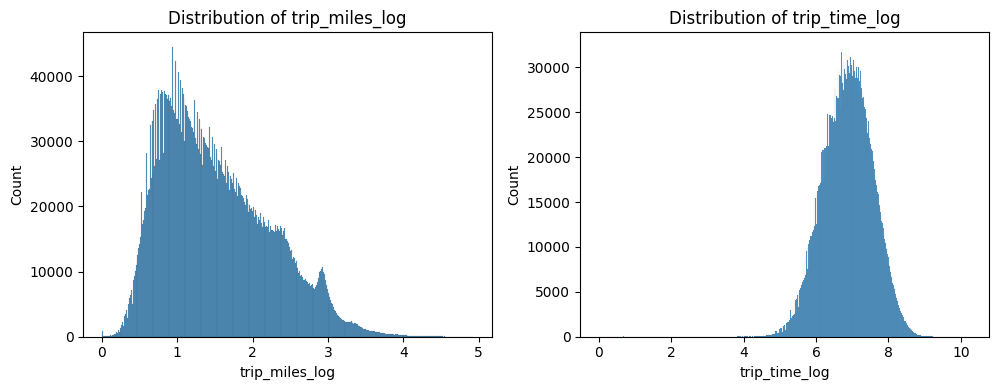

In [40]:
df['trip_miles_log'] = np.log(df['trip_miles']+1)
df['trip_time_log'] = np.log(df['trip_time']+1)
features_to_plot.extend(['trip_miles_log', 'trip_time_log'])
histogram_plot(['trip_miles_log', 'trip_time_log'])

Not perfect but good enough for XGBoost.

Also, from the graph above, <br>
it seems not all shared_request_flag were shared_match_flagged, <br>
and not all wav_match_flag were due to wav_request_flag.

In [41]:
print('shared_request_flag of people who got matched for a shared ride')
print(df[df['shared_match_flag'] == 'Y'].shared_request_flag.unique())
print('wav_match_flag of people who requested wav ride')
print(df[df['wav_request_flag'] == 'Y'].wav_match_flag.unique())

shared_request_flag of people who got matched for a shared ride
['Y' 'N']
wav_match_flag of people who requested wav ride
['Y' 'N']


In [42]:
# That's not expected. Check.
print(len(df[(df['shared_match_flag'] == 'Y') & (df['shared_request_flag'] == 'N')]))
print(len(df[(df['wav_match_flag'] == 'N') & (df['wav_request_flag'] == 'Y')]))
print(df[(df['shared_match_flag'] == 'Y') & (df['shared_request_flag'] == 'N')].hvfhs_license_num.unique())
print(df[(df['wav_match_flag'] == 'N') & (df['wav_request_flag'] == 'Y')].hvfhs_license_num.unique())

77
1
['HV0005']
['HV0005']


So there are quite a few people who didn't request a shared ride, but got into a shared ride.<br>
There are people requesting wav ride but not getting it. <br>
And its all Lyft.

Let's sweep it under the rug for them. <br>
Its very small number compared to the total, and will improve the model by doing so.

In [43]:
df = df[~((df['shared_match_flag'] == 'Y') & (df['shared_request_flag'] == 'N'))]
df = df[~((df['wav_match_flag'] == 'N') & (df['wav_request_flag'] == 'Y'))]

#### Geographic Data Engineering
trip_miles is there, but potentially some information from DOLocationID and PULocationID can be pulled. <br>
Pull a taxi zone map.

In [44]:
import geopandas as gpd

map = gpd.read_file(os.path.join(data_path, 'taxi_zones.shp'))
print(map.crs)
map.head()

EPSG:2263


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


In [45]:
# Get Zone, LocationID, and geometry
map = map[['zone', 'LocationID', 'geometry']]
map.head()

,zone,LocationID,geometry
0,Newark Airport,1,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,Jamaica Bay,2,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,Allerton/Pelham Gardens,3,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,Alphabet City,4,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,Arden Heights,5,"POLYGON ((935843.31 144283.336, 936046.565 144..."


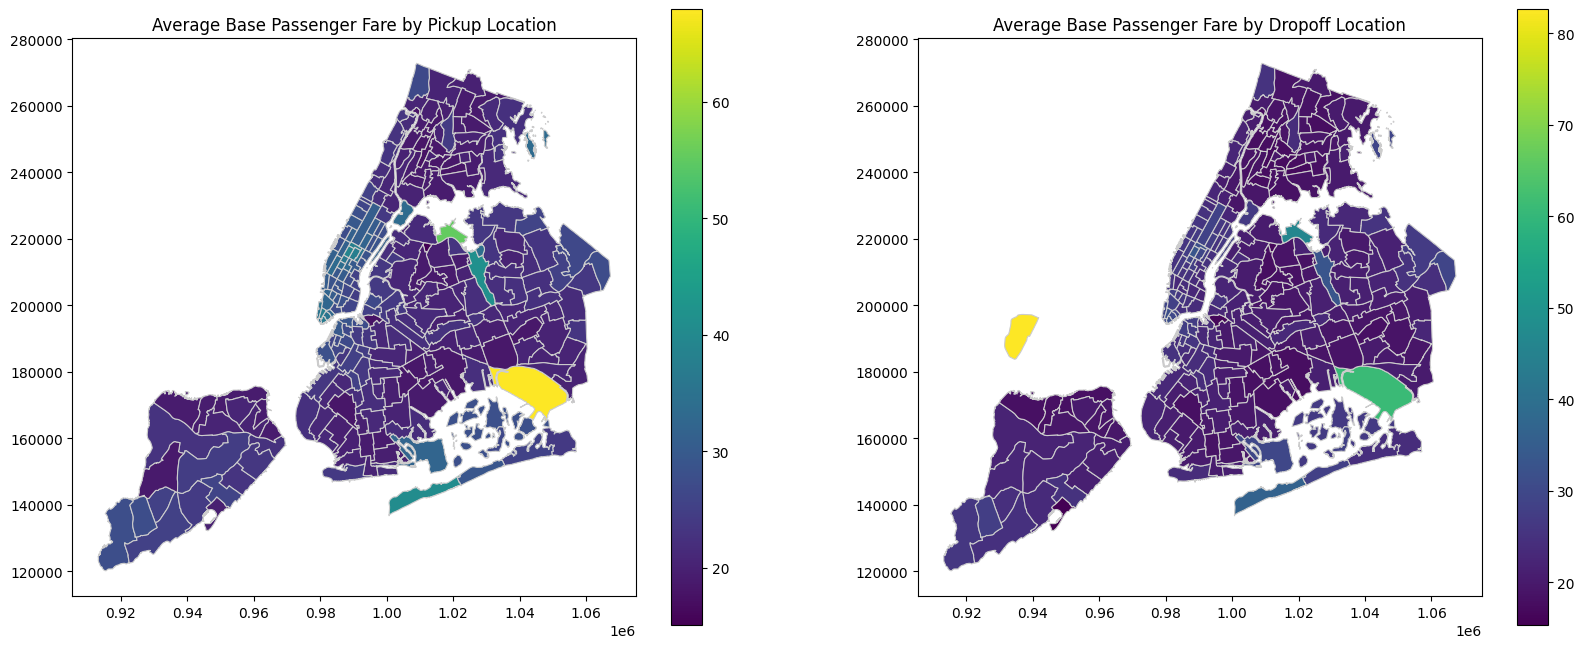

In [46]:
# PULocationID average base_passenger_fare
pulocation_fare = df.groupby('PULocationID')['base_passenger_fare'].mean().reset_index()
pulocation_fare.rename(columns={'PULocationID': 'LocationID', 'base_passenger_fare': 'avg_fare_pickup'}, inplace=True)

# DOLocationID average base_passneger_fare
dolocation_fare = df.groupby('DOLocationID')['base_passenger_fare'].mean().reset_index()
dolocation_fare.rename(columns={'DOLocationID': 'LocationID', 'base_passenger_fare': 'avg_fare_dropoff'}, inplace=True)

# Merge with the map GeoDataFrame for pickup locations
pickup_map = map.merge(pulocation_fare, on='LocationID', how='left')
dropoff_map = map.merge(dolocation_fare, on='LocationID', how='left')

# Plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
pickup_map.plot(column='avg_fare_pickup', cmap='viridis', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
ax[0].set_title('Average Base Passenger Fare by Pickup Location')
dropoff_map.plot(column='avg_fare_dropoff', cmap='viridis', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True)
ax[1].set_title('Average Base Passenger Fare by Dropoff Location')
plt.show()

del pulocation_fare, dolocation_fare, pickup_map, dropoff_map

All the airports are expensive.<br>
Dropoff only for Newark Airport. <br>
Manhattan pickup is more expensive than dropoff.

Create a column in df that measures the distance between the centroids of  DOLocationID and PULocationID.

In [47]:
# Distance measurement failed due to DOLocationID and PULocationID having LocationID not on Map

df_location_ids = pd.concat([df['DOLocationID'], df['PULocationID']]).unique()
missing_locations = np.setdiff1d(df_location_ids, map['LocationID'].unique())
print("Location IDs in df not found in map:", missing_locations)

Location IDs in df not found in map: [ 57 105 265]


In [48]:
map.iloc[55:58]

,zone,LocationID,geometry
55,Corona,56,"POLYGON ((1024813.399 211643.796, 1024910.997 ..."
56,Corona,56,"POLYGON ((1025447.751 212499.788, 1024585.351 ..."
57,Country Club,58,"POLYGON ((1035263.069 248349.465, 1035243.096 ..."


In [49]:
map.iloc[101:107]

,zone,LocationID,geometry
101,Glendale,102,"POLYGON ((1024186.946 196680.736, 1024191.248 ..."
102,Governor's Island/Ellis Island/Liberty Island,103,"POLYGON ((972079.575 190732.429, 972184.766 19..."
103,Governor's Island/Ellis Island/Liberty Island,103,"POLYGON ((973172.666 194632.348, 973310.63 194..."
104,Governor's Island/Ellis Island/Liberty Island,103,"POLYGON ((979605.759 191880.575, 979978.435 19..."
105,Gowanus,106,"POLYGON ((988104.225 187386.493, 988649.315 18..."
106,Gramercy,107,"POLYGON ((989131.643 205749.904, 989084.531 20..."


In [50]:
map.iloc[260:264]

,zone,LocationID,geometry
260,World Trade Center,261,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,Yorkville East,262,"MULTIPOLYGON (((999804.795 224498.527, 999824...."
262,Yorkville West,263,"POLYGON ((997493.323 220912.386, 997355.264 22..."


LocationID 265 was "Outside of NYC" <br>
Update the map table correctly and calculate the distance between the centroids of  DOLocationID and PULocationID.<br>
If either DOLocationID or PULocationID is 265, use trip_miles.

In [51]:
# Update Map Table
map.at[56, 'LocationID'] = 57
map.at[103, 'LocationID'] = 104
map.at[104, 'LocationID'] = 105

In [52]:
# Make centroids, and x y coordinates
map['centroid'] = map['geometry'].centroid
map['centroid_x'] = map['centroid'].x
map['centroid_y'] = map['centroid'].y

# Merge map centroids with df for pickup and dropoff locations
df = df.merge(map[['LocationID', 'centroid_x' , 'centroid_y']], left_on='PULocationID', right_on='LocationID', how='left')
df.rename(columns={'centroid_x': 'pickup_lon', 'centroid_y': 'pickup_lat'}, inplace=True)
df = df.drop(columns=['LocationID'])

df = df.merge(map[['LocationID', 'centroid_x', 'centroid_y']], left_on='DOLocationID', right_on='LocationID', how='left')
df.rename(columns={'centroid_x': 'dropoff_lon', 'centroid_y': 'dropoff_lat'}, inplace=True)
df = df.drop(columns=['LocationID'])

# Fill missing lon and lan for LocationID 265.
df['pickup_lon'] = df['pickup_lon'].fillna(-999999).astype(float)
df['pickup_lat'] = df['pickup_lat'].fillna(-999999).astype(float)
df['dropoff_lon'] = df['dropoff_lon'].fillna(-999999).astype(float)
df['dropoff_lat'] = df['dropoff_lat'].fillna(-999999).astype(float)

# Calculate distance
df['distance'] = ((df['dropoff_lon'] - df['pickup_lon'])**2 + (df['dropoff_lat'] - df['pickup_lat'])**2) ** 0.5


In [53]:
# In EPSG 2263, the distance should be in feet.
df['distance'] = df['distance'] / 5280

In [54]:
# Indicator column showing if the trip was from outside NYC
df['distance_outofNYC'] = ((df['PULocationID'] == 265) | (df['DOLocationID'] == 265))

In [55]:
# If from outofNYC, distance is 0
df['distance'] = np.where(
    df['distance_outofNYC'] == True,
    -1,
    df['distance']
)

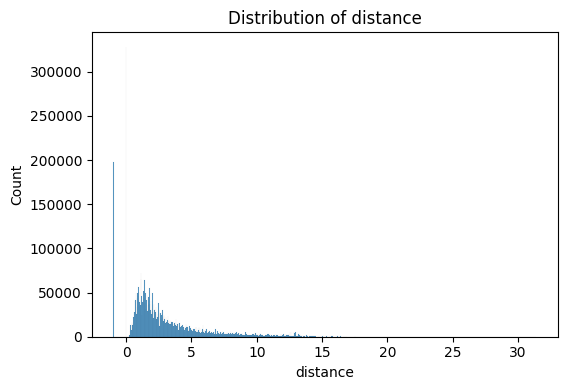

count    4.784293e+06
mean     2.927695e+00
std      2.998386e+00
min     -1.000000e+00
25%      1.045424e+00
50%      2.003263e+00
75%      3.904663e+00
max      3.139878e+01
Name: distance, dtype: float64


In [56]:
# Draw it out
histogram_plot(['distance'])
print(df['distance'].describe())

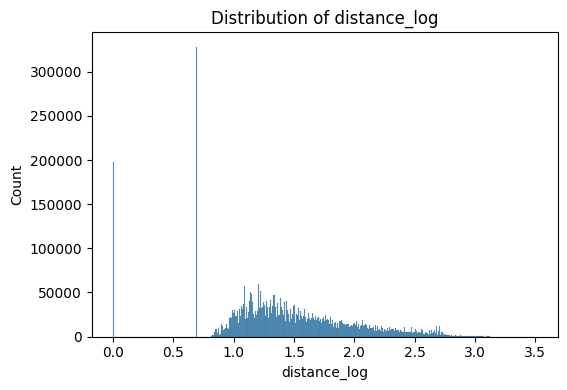

In [57]:
# Apply log transformation
df['distance_log'] = np.log(df['distance']+2)
histogram_plot(['distance_log'])

In [58]:
df[df['distance'] == 0]

,DOLocationID,PULocationID,access_a_ride_flag,airport_fee,base_passenger_fare,bcf,congestion_surcharge,hvfhs_license_num,on_scene_datetime,originating_base_num,pickup_datetime,request_datetime,shared_match_flag,shared_request_flag,tolls,trip_miles,trip_time,wav_match_flag,wav_request_flag,on_scene_datetime_missing,bcf_trans,base_passenger_fare_log,trip_miles_log,trip_time_log,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,distance,distance_outofNYC,distance_log
7,80,80,N,0.0,7.15,0.20,0.00,HV0005,2023-10-01 00:00:00,Missing,2024-01-21 02:12:20,2024-01-21 02:03:37,N,N,0.0,0.762,218,N,N,True,-1.592750,1.967112,0.566450,5.389072,1.001772e+06,199911.286345,1.001772e+06,199911.286345,0.0,False,0.693147
10,42,42,N,0.0,8.06,0.22,0.00,HV0005,2023-10-01 00:00:00,Missing,2024-01-07 11:59:01,2024-01-07 11:53:51,N,N,0.0,0.406,127,N,N,True,-1.465406,2.086914,0.340749,4.852030,1.000644e+06,237395.871548,1.000644e+06,237395.871548,0.0,False,0.693147
35,148,148,N,0.0,8.06,0.22,2.75,HV0003,2024-01-08 02:42:03,B03404,2024-01-08 02:42:29,2024-01-08 02:40:53,N,N,0.0,0.570,204,N,N,False,-1.465406,2.086914,0.451076,5.323010,9.867735e+05,201205.264892,9.867735e+05,201205.264892,0.0,False,0.693147
42,82,82,N,0.0,10.74,0.30,0.00,HV0003,2024-01-15 04:31:24,B03404,2024-01-15 04:31:28,2024-01-15 04:29:25,N,N,0.0,1.470,507,N,N,False,-1.012771,2.373975,0.904218,6.230481,1.018303e+06,208718.589250,1.018303e+06,208718.589250,0.0,False,0.693147
78,223,223,N,0.0,8.88,0.24,0.00,HV0003,2024-01-12 23:39:24,B03404,2024-01-12 23:39:24,2024-01-12 23:36:47,N,N,0.0,0.420,158,N,N,False,-1.344099,2.183802,0.350657,5.068904,1.010448e+06,222528.476020,1.010448e+06,222528.476020,0.0,False,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784207,51,51,N,0.0,12.51,0.35,0.00,HV0003,2024-12-23 18:48:01,B03404,2024-12-23 18:49:14,2024-12-23 18:32:50,N,N,0.0,1.960,1054,N,N,False,-0.769346,2.526528,1.085189,6.961296,1.031745e+06,257736.031773,1.031745e+06,257736.031773,0.0,False,0.693147
4784221,181,181,N,0.0,10.05,0.29,0.00,HV0003,2024-12-01 21:26:31,B03404,2024-12-01 21:26:35,2024-12-01 21:24:06,N,N,0.0,1.520,512,N,N,False,-1.064839,2.307573,0.924259,6.240276,9.894057e+05,183512.266066,9.894057e+05,183512.266066,0.0,False,0.693147
4784237,210,210,N,0.0,11.61,0.32,0.00,HV0003,2024-12-18 08:56:31,B03404,2024-12-18 08:57:56,2024-12-18 08:49:03,N,N,0.0,1.600,626,N,N,False,-0.912120,2.451867,0.955511,6.440947,1.000773e+06,154972.187945,1.000773e+06,154972.187945,0.0,False,0.693147
4784268,83,83,N,0.0,9.83,0.27,0.00,HV0003,2024-12-05 10:25:21,B03404,2024-12-05 10:27:21,2024-12-05 10:24:23,N,N,0.0,0.280,203,N,N,False,-1.172640,2.285439,0.246860,5.318120,1.014131e+06,208286.312746,1.014131e+06,208286.312746,0.0,False,0.693147


In [59]:
# Drop unnecessary values
df = df.drop(columns=['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat'])
del map

#### Time data Engineering

It seems as though all features except datetime features exhibit some information about the fare.<br>
Potentially, they are not as obvious and needs to be transformed.

Three datetime features are available. <br>
Three numbers can be extracted, but only two will be kept since they are perfectly collinear.
- pickup - request = request_to_pickup
- on_scene - request = time_to_arrival
- pickup - on_scene = driver_wait_time

request_to_pickup should be kept as no rows were imputed. <br>
time_to_arrival will be kept as well since it is more relevant as an indicator of driver availability.<br>

Also, extract time related data from pickup_datetime. <br>
New features related to time of the day can be created.<br>
Extract cyclic data as well.

In [60]:
# Update time features
df['request_to_pickup'] = (df['pickup_datetime'] - df['request_datetime']).dt.total_seconds().astype('int64')
df['request_to_on_scene'] = (df['on_scene_datetime'] - df['request_datetime']).dt.total_seconds().astype('int64')

# pickup_datetime time extraction
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_minute'] = df['pickup_datetime'].dt.minute

# time of the day
df['is_morning'] = df['pickup_hour'].between(6, 11)
df['is_afternoon'] = df['pickup_hour'].between(12, 17)     
df['is_evening'] = df['pickup_hour'].between(18, 20) 
# is_night is not needed as it is collinear
df['is_rush_hour'] = df['pickup_hour'].isin([7, 8, 16, 17, 18]) & df['pickup_weekday'].isin([0,1,2,3,4])
df['is_weekend'] = df['pickup_weekday'].isin([5, 6])

# Capture cyclic data
def create_cyclical_features(df, col_name, period):
    sin_col = f'{col_name}_sin'
    cos_col = f'{col_name}_cos'
    df[sin_col] = np.sin(2 * np.pi * df[col_name] / period)
    df[cos_col] = np.cos(2 * np.pi * df[col_name] / period)
    return df

df = create_cyclical_features(df, 'pickup_hour', 24)
df = create_cyclical_features(df, 'pickup_weekday', 7)
df = create_cyclical_features(df, 'pickup_month', 12)
df = create_cyclical_features(df, 'pickup_minute', 60)

month_days = {1:31, 2:29, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
df = create_cyclical_features(df, 'pickup_day', df['pickup_month'].map(month_days))


In [61]:
df = df.drop(columns=['pickup_datetime', 'on_scene_datetime', 'request_datetime'])

#### Additional Data/Info

Add some relevant data that could be helpful in predicting the fare
- Weather
- Holidays

In [62]:
# Get 2024 Weather info
# Weather API from https://open-meteo.com/en/docs/historical-weather-api

import openmeteo_requests

import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2023-12-31",
	"end_date": "2024-12-31",
	"hourly": "weather_code",
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_weather_code = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["weather_code"] = hourly_weather_code

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone b'America/New_York'b'GMT-4'
Timezone difference to GMT+0 -14400 s
                          date  weather_code
0    2023-12-31 04:00:00+00:00           0.0
1    2023-12-31 05:00:00+00:00           0.0
2    2023-12-31 06:00:00+00:00           0.0
3    2023-12-31 07:00:00+00:00           0.0
4    2023-12-31 08:00:00+00:00           0.0
...                        ...           ...
8803 2024-12-31 23:00:00+00:00           3.0
8804 2025-01-01 00:00:00+00:00           3.0
8805 2025-01-01 01:00:00+00:00           3.0
8806 2025-01-01 02:00:00+00:00          63.0
8807 2025-01-01 03:00:00+00:00          63.0

[8808 rows x 2 columns]


Still has some non 2024 info. Remove them.

In [63]:
# Remove non 2024 info
hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])
hourly_dataframe = hourly_dataframe[hourly_dataframe['date'].dt.year == 2024]
hourly_dataframe.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 20 to 8803
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          8784 non-null   datetime64[ns, UTC]
 1   weather_code  8784 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(1)
memory usage: 171.6 KB


In [64]:
# Make hourly data from df to match 'date' format from hourly_dateframe
month_str = df['pickup_month'].astype(str).str.zfill(2)
day_str = df['pickup_day'].astype(str).str.zfill(2)
hour_str = df['pickup_hour'].astype(str).str.zfill(2)
datetime_str = '2024-' + month_str + '-' + day_str + ' ' + hour_str + ':00:00+00:00'
df['pickup_hourly'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M:%S%z')
# Merge
df = pd.merge(df, hourly_dataframe, left_on='pickup_hourly', right_on='date', how='left')
# Drop unnecessary values
df = df.drop(columns=['date','pickup_hourly'])
del hourly_dataframe

In [65]:
# Holidays

holidays_2024 = {
    (1, 1): "New Year's Day",
    (1, 15): "Martin Luther King Jr. Day",
    (2, 12): "Lincoln's Birthday",
    (2, 15): "Susan B. Anthony Day",
    (2, 19): "Washington's Birthday",
    (5, 27): 'Memorial Day',
    (6, 19): 'Juneteenth National Independence Day',
    (7, 4): 'Independence Day',
    (9, 2): 'Labor Day',
    (10, 14): 'Columbus Day',
    (11, 5): 'Election Day',
    (11, 11): 'Veterans Day',
    (11, 28): 'Thanksgiving Day',
    (12, 25): 'Christmas Day'
}

pickup_dates = pd.Series(zip(df['pickup_month'], df['pickup_day']))

df['is_holiday'] = pickup_dates.isin(holidays_2024.keys())

#### Encoding

Binary features will be encoded now.

In [66]:
# Extract binary features
binary_features = []

for col in df.columns: 
    if df[col].nunique() == 2:
        binary_features.append(col)

In [67]:
df[binary_features]

,access_a_ride_flag,hvfhs_license_num,shared_match_flag,shared_request_flag,wav_match_flag,wav_request_flag,on_scene_datetime_missing,distance_outofNYC,is_morning,is_afternoon,is_evening,is_rush_hour,is_weekend,is_holiday
0,N,HV0005,N,N,Y,N,True,False,False,False,False,False,False,False
1,N,HV0003,N,N,N,N,False,False,True,False,False,True,False,False
2,N,HV0003,N,N,N,N,False,False,False,False,False,False,False,False
3,N,HV0003,N,N,N,N,False,False,False,False,False,False,True,False
4,N,HV0005,N,N,N,N,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784288,N,HV0003,N,N,N,N,False,False,True,False,False,False,False,False
4784289,N,HV0003,N,N,N,N,False,False,False,True,False,False,False,False
4784290,N,HV0003,N,N,N,N,False,False,False,False,False,False,False,False
4784291,N,HV0005,N,N,N,N,True,False,False,True,False,False,True,False


LabelEncoder could be used, but the preference is to have False and N to be 0 and True and Y to be 1.


In [68]:
mapping = {
    'N': 0,
    'Y': 1,
    False: 0,
    True: 1,
    'HV0003': 0, #Uber
    'HV0005': 1 #Lyft
}

for col in binary_features:
    df[col] = df[col].map(mapping).astype(int)

Check the remaining other categorical features 

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4784293 entries, 0 to 4784292
Data columns (total 48 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   DOLocationID               int32  
 1   PULocationID               int32  
 2   access_a_ride_flag         int32  
 3   airport_fee                float64
 4   base_passenger_fare        float64
 5   bcf                        float64
 6   congestion_surcharge       float64
 7   hvfhs_license_num          int32  
 8   originating_base_num       object 
 9   shared_match_flag          int32  
 10  shared_request_flag        int32  
 11  tolls                      float64
 12  trip_miles                 float64
 13  trip_time                  int64  
 14  wav_match_flag             int32  
 15  wav_request_flag           int32  
 16  on_scene_datetime_missing  int32  
 17  bcf_trans                  float64
 18  base_passenger_fare_log    float64
 19  trip_miles_log             float64
 20  tr

DOLocationID, PULocationID, originating_base_num, weather are categorical features. <br>
DOLocationID, PULocationID, and originating_base_num will be one-hot encoded when a model is developed if selected as a feature to avoid data leakage.<br>
weather_code is ordinal, but is spread out. Manually ordinal encode.

In [70]:
# Encode weather
weather_codes = sorted(df['weather_code'].unique())
code_map = {code: i for i, code in enumerate(weather_codes)}
df['weather_code'] = df['weather_code'].map(code_map)

#### Scaling

Scaling is done during model development to prevent data leakage.

## Model Development
### base_passenger_fare prediction
#### Feature Selection

Lets first draw correlation to see overall picture.

In [71]:
# Correlation

import plotly.graph_objects as go

cor = df.corr(numeric_only=True)

fig = go.Figure(data=go.Heatmap(
    z=cor.values,
    x=cor.columns,
    y=cor.columns,
    colorscale='RdBu',
    zmin=-1,
    zmax=1
))

fig.update_layout(
    title='Correlation Heatmap',
    xaxis_title='Features',
    yaxis_title='Features',
    width=1400,
    height=1400,
    margin=dict(l=30, r=30, b=30, t=30, pad=4)
)

fig.show()

In [72]:
# Make lists of features that could be used for base_passenger_fare_log model and remove them as appropriate.
bf_categorical_features = [
    'DOLocationID', 
    'PULocationID', 
    'originating_base_num', 
    'weather_code'
    ]
bf_binary_features = [
    'access_a_ride_flag', 
    'shared_match_flag', 
    'shared_request_flag', 
    'wav_match_flag', 
    'wav_request_flag', 
    'on_scene_datetime_missing', 
    'distance_outofNYC', 
    'is_morning', 
    'is_afternoon', 
    'is_evening', 
    'is_rush_hour', 
    'is_weekend', 
    'is_holiday'
    ]

bf_numeric_features = [col for col in df.columns if col not in bf_categorical_features + bf_binary_features + target_features]

Draw features against base_passenger_fare_log to see what it looks like.

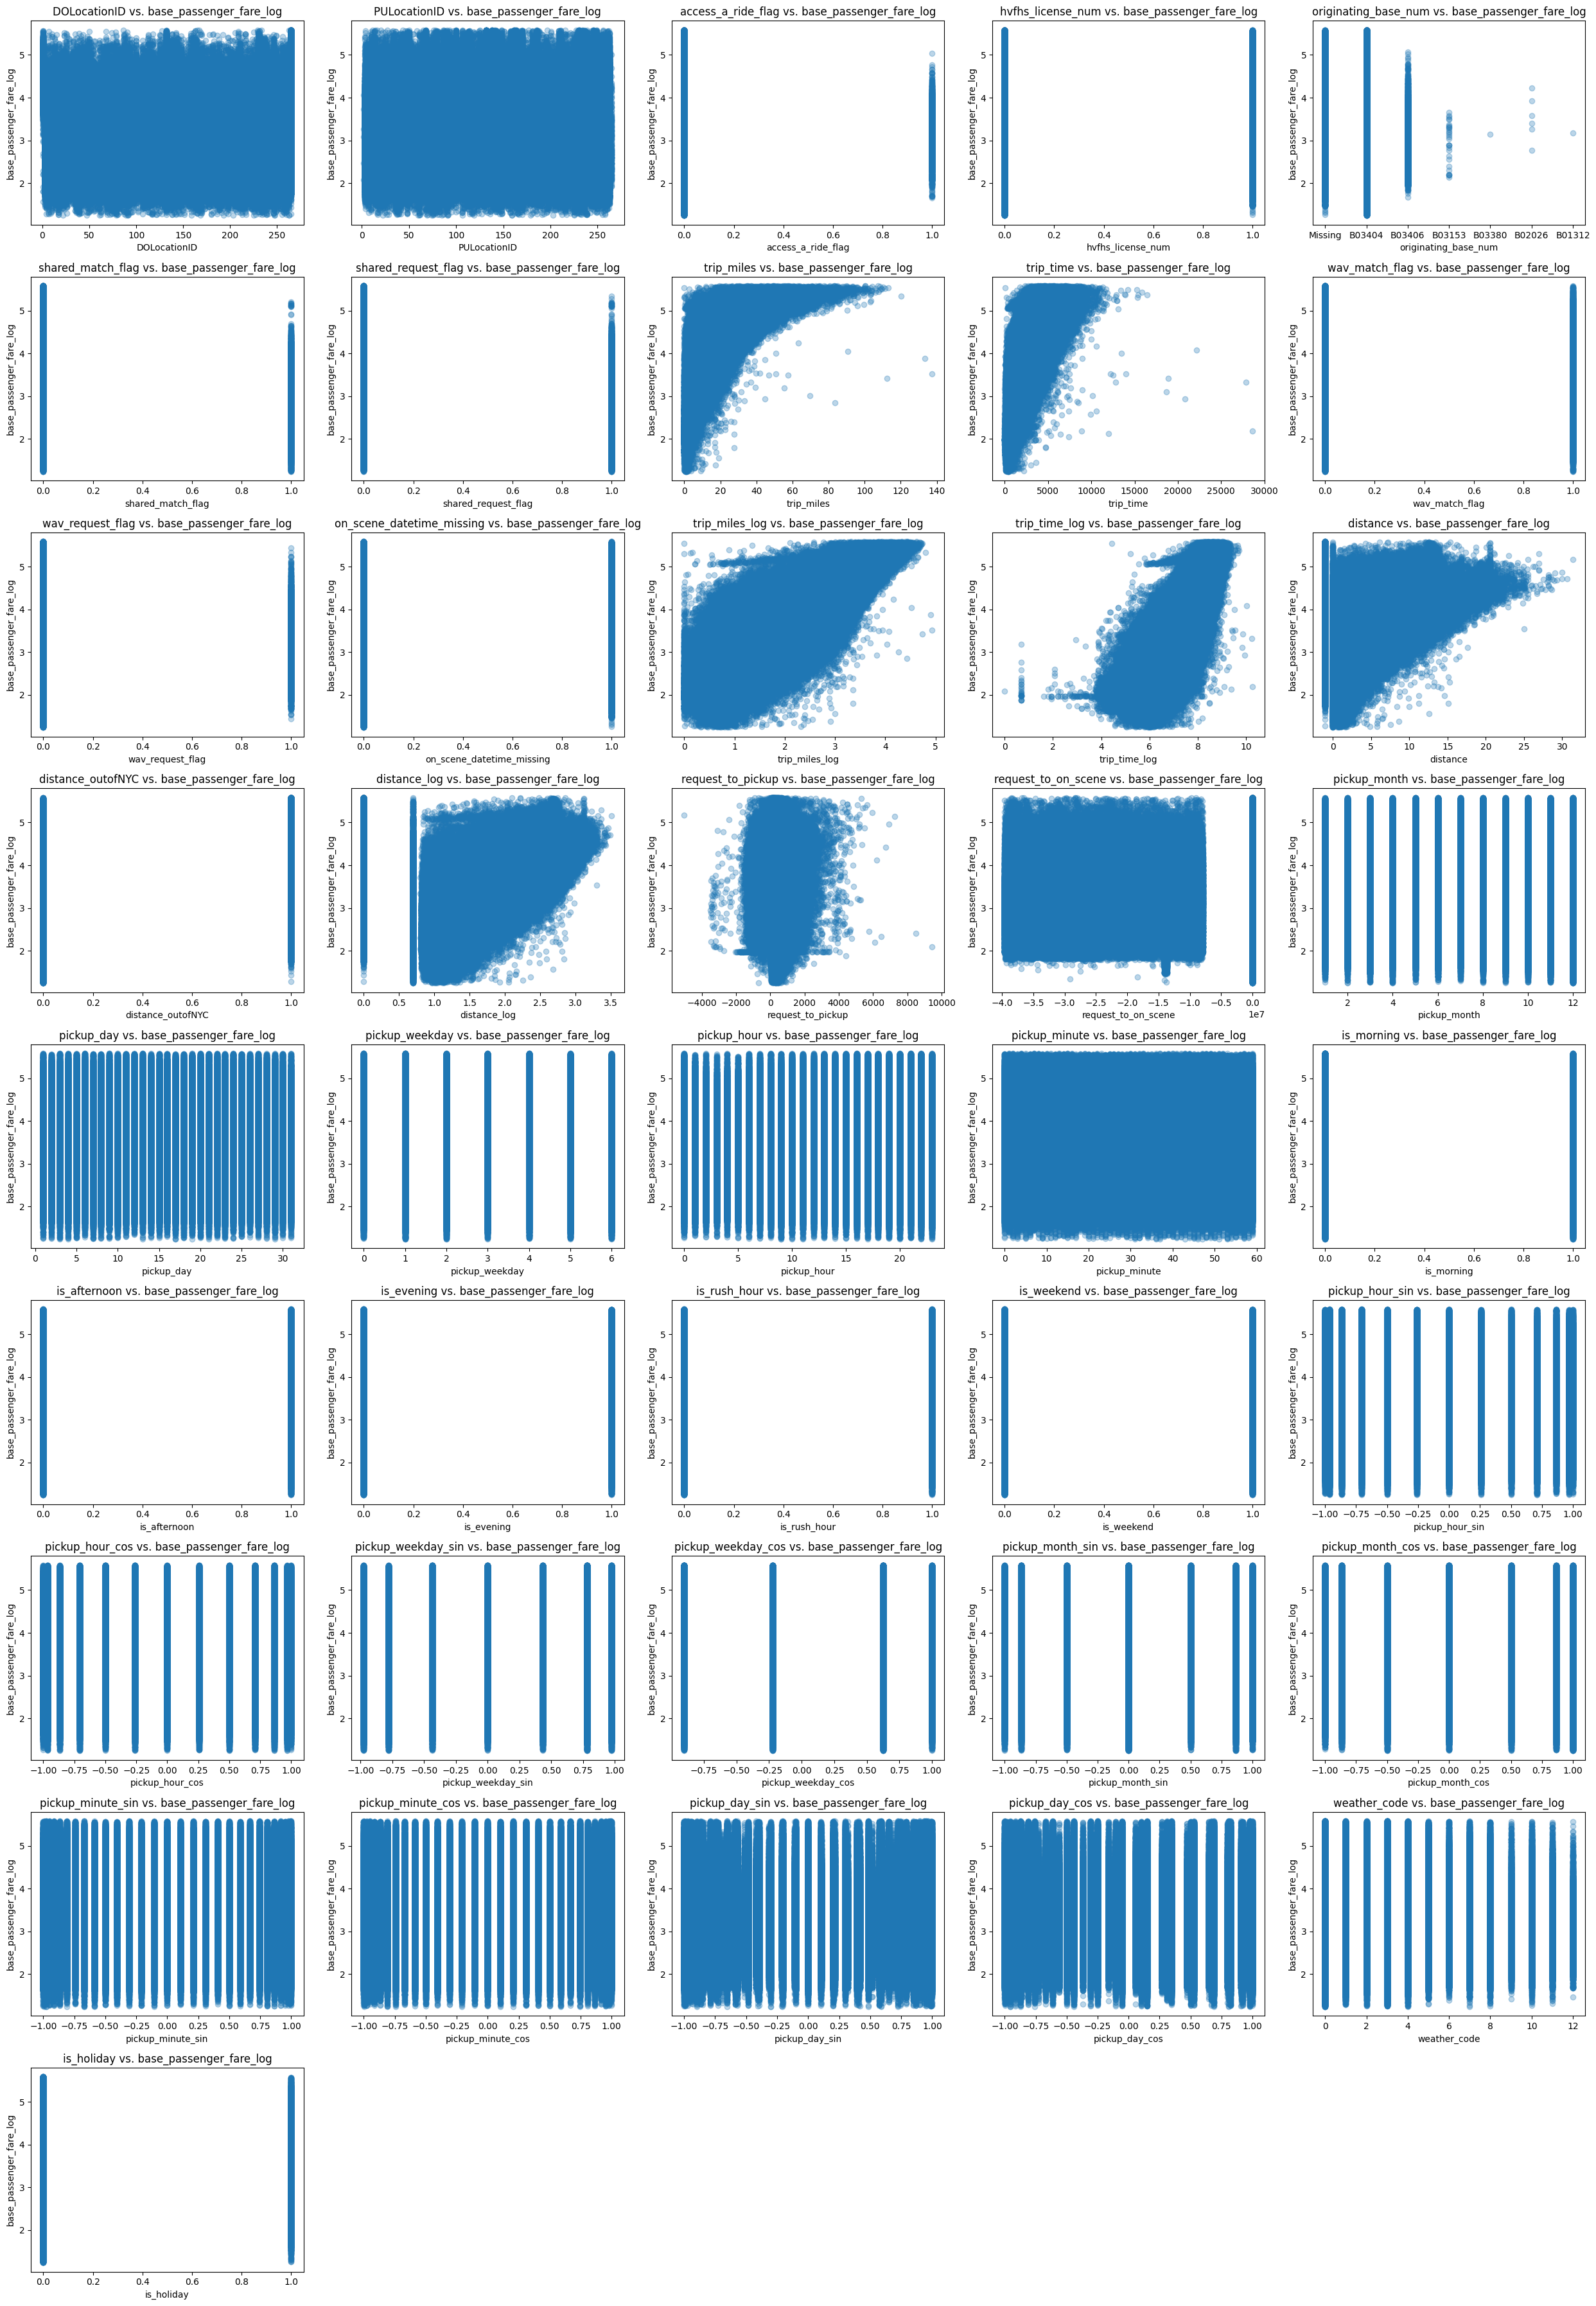

In [73]:
features_to_plot = [col for col in df.columns if col not in target_features]

def plot_2d(features_to_plot, target_column):
    
    num_features = len(features_to_plot)
    num_cols = 5
    num_rows = (num_features + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 4 * num_rows))
    axs = axs.flatten()

    for i, feature in enumerate(features_to_plot):
        ax = axs[i]
        ax.scatter(df[feature], df[target_column], alpha=0.3)
        ax.set_xlabel(feature)
        ax.set_ylabel(target_column)
        ax.set_title(f'{feature} vs. {target_column}')

    for i in range(num_features, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

plot_2d(features_to_plot, 'base_passenger_fare_log')

trip_mile_log, trip_time_log, distance_log, request_to_pickup seems to have some correlation with base_passenger_fare_log.<br>
Most categorical features except access_a_ride_flag, originating_base_num, wav_request_flag seems completely unrelated.<br>
Check additional metrics to help with feature selection: VIF, mutual information.

In [74]:
# VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_matrix = pd.DataFrame(index=bf_numeric_features, columns=['VIF'])

for i, col in enumerate(bf_numeric_features):
    vif = variance_inflation_factor(df[bf_numeric_features].values, i)
    vif_matrix.loc[col, 'VIF'] = vif

vif_matrix = vif_matrix.sort_values(by='VIF', ascending=False)

pd.set_option('display.max_rows',None)
vif_matrix

,VIF
trip_time_log,127.327218
distance_log,93.6879
trip_miles_log,54.10439
distance,30.395352
trip_miles,14.38166
pickup_month,13.44452
pickup_hour,12.769995
trip_time,12.423172
pickup_weekday,10.777472
pickup_day,10.697085


In [75]:
# Mutual Information
# Facing some memory issues, sampling to proceed

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=42)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Create a copy of the dataframe to avoid modifying the original
df_mi = df.copy()

# Reduce categories in categorical features
for col in bf_categorical_features:
    counts = df_mi[col].value_counts()
    rare_categories = counts[counts < 100].index
    df_mi[col] = df_mi[col].replace(rare_categories, 'Other')

# Sample a subset of the data
df_mi_sampled = df_mi.sample(n=100000, random_state=42)  # Adjust sample size as needed

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True) # Use sparse matrices
encoder.fit(df_mi_sampled[bf_categorical_features])
X_categorical = encoder.transform(df_mi_sampled[bf_categorical_features])
feature_names = encoder.get_feature_names_out(input_features=bf_categorical_features)
X_categorical = pd.DataFrame.sparse.from_spmatrix(X_categorical, columns=feature_names, index=df_mi_sampled.index)

# Combine categorical and numerical features
X = pd.concat([X_categorical, df_mi_sampled[bf_binary_features + bf_numeric_features]], axis=1)
y = df_mi_sampled['base_passenger_fare_log']

# All one-hot encoded features are discrete, mark binary features as discrete as well
discrete_features = [True] * len(feature_names) + [True] * len(bf_binary_features) + [False] * len(bf_numeric_features)

mi_scores = make_mi_scores(X, y, discrete_features)

del df_mi, df_mi_sampled

mi_scores

trip_miles_log                  0.782125
trip_miles                      0.776473
trip_time_log                   0.773157
trip_time                       0.773112
distance_log                    0.614822
distance                        0.611615
hvfhs_license_num               0.049961
originating_base_num_B03404     0.049221
on_scene_datetime_missing       0.048944
originating_base_num_Missing    0.048944
DOLocationID_265                0.044221
distance_outofNYC               0.044182
request_to_on_scene             0.033639
DOLocationID_132                0.023495
PULocationID_132                0.022023
PULocationID_138                0.019888
DOLocationID_138                0.018153
pickup_month                    0.016524
DOLocationID_1                  0.016316
request_to_pickup               0.012157
shared_request_flag             0.010493
pickup_month_cos                0.010389
pickup_hour                     0.006918
pickup_month_sin                0.006523
pickup_hour_sin 

<b>Correlation:</b><br>
other than the target features, base_passenger_fare_log has a strong correlation with trip_miles_log, trip_time_log, and distance. <br>
correlation between the logged variables are stronger than the correlation between original variables. (ex.base_passenger_fare vs trip_miles, trip_time) <br>

<b>VIF:</b><br>
High VIF for features with transformation.<br>
trip_miles and trip_time should be removed as log version has higher correlation to base_passenger_fare_log.<br>
distance_log should be removed as original has higher correlation.

pickup_ months, days, hour, minute are removed as cyclic transformation are available.

hvfhs_license_num and request_to_on_scene show high VIF.<br>
one of them could be removed.

<b>Mutual Information:</b><br>
High mutual information for trip miles, trip time, and distance.<br>

hvfhs_license_num, originating_base_num, and on_scene_datetime have similar MI score.<br>
originating base_num is highly correlated to hvfhs_license_num as all base_num is a subgroup of Uber/Lyft, and all missing_base_num comes from Lyft.<br>
on_scene_datetime missing is also coming from Lyft only, so highly correlated to hvfhs_license_num.<br>
Removing hvfhs_license_num will prevent collinearity. Uber/Lyft can still be identified from base_num.

All the pickup_time and cycle data seems irrelevant.

That leaves trip_miles_log, trip_time_log, distance, request_to_pickup, and request_to_on_scene on numerical features
<br><br>

weather_code seems irrelevant based on correlation and MI score.

time of the day seems irrelevant based on correlation and MI score.

wav_request_flag and shared_match_flag seems less relavent than wav_match_flag and shared_request_flag based on correlation and MI score.

<br><br>
Remove those columns and check VIF again.

In [76]:
bf_numeric_features = [
    'trip_miles_log',
    'trip_time_log',
    'distance',
    'request_to_pickup',
    'request_to_on_scene'
    ]

bf_categorical_features = [
    'DOLocationID', 
    'PULocationID', 
    'originating_base_num'
    ]

bf_binary_features = [
    'access_a_ride_flag',
    'shared_request_flag',
    'wav_match_flag',
    'on_scene_datetime_missing',
    'distance_outofNYC'
    ]

In [77]:
# VIF
vif_matrix = pd.DataFrame(index=bf_numeric_features, columns=['VIF'])

for i, col in enumerate(bf_numeric_features):
    vif = variance_inflation_factor(df[bf_numeric_features].values, i)
    vif_matrix.loc[col, 'VIF'] = vif

vif_matrix = vif_matrix.sort_values(by='VIF', ascending=False)

pd.set_option('display.max_rows',None)
vif_matrix

,VIF
trip_miles_log,14.646116
trip_time_log,11.471164
distance,3.980466
request_to_pickup,2.918075
request_to_on_scene,1.289429


VIF of trip_miles_log and trip_time_log is still very high.<br>
They are bound to be collinear, but they could be different <br>
Keep trip_miles_log and trip_time_log for now.<br>
13 features are selected to model base_passenger_fare.

#### Modeling

Finally! Model for base_passenger_fare.<br>
One-hot encode categorical features.<br>
Scale numerical features.

In [79]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# features and target
features = bf_categorical_features + bf_binary_features + bf_numeric_features
target = 'base_passenger_fare_log'

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), bf_numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), bf_categorical_features)
    ])

# Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=0))
])

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
y_test_normal = np.exp(y_test)
y_pred_normal = np.exp(y_pred)

# Evaluate on the normal scale
mae_normal = mean_absolute_error(y_test_normal, y_pred_normal)
rmse = np.sqrt(mean_squared_error(y_test_normal, y_pred_normal))
r2 = r2_score(y_test_normal, y_pred_normal)
print(f"MAE (Normal Scale): ${mae_normal:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE (Normal Scale): $4.60
RMSE: $8.85
R²: 0.8395


MAE of $4.60 and r-square of 0.8395 sounds ok-ish.

#### Hyperparameter tuning

Let's tune parameters to see if the model can be better.
With enough time and resources, perform GridSearch.

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

# pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=0))
])

# Grid Search Parameter
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__learning_rate': [0.1, 0.3, 0.5]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=1,  # Only if more ram was available
    verbose=2
)

# grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=100; total time=   5.8s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=100; total time=   5.7s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=100; total time=   5.3s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200; total time=   7.6s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200; total time=   7.7s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200; total time=   7.6s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=300; total time=   9.9s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=300; total time=   9.9s
[CV] END regressor__learning_rate=0.1, regressor__

#### Model Evaluation

In [ ]:
# Best Parameters: {'regressor__learning_rate': 0.3, 'regressor__max_depth': 9, 'regressor__n_estimators': 300}
# Confirm the model with best parameters

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

y_test_normal = np.exp(y_test)
y_pred_normal = np.exp(y_pred)

mae_normal = mean_absolute_error(y_test_normal, y_pred_normal)
rmse = np.sqrt(mean_squared_error(y_test_normal, y_pred_normal))
r2 = r2_score(y_test_normal, y_pred_normal)
print(f"MAE (Normal Scale): ${mae_normal:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE (Normal Scale): $4.42
RMSE: $8.48
R²: 0.8527


4.42 is better than 4.60 for MAE.<br>
.8527 is better than 0.8395 for r-squared. <br>

In [90]:
# Feature importance
feature_names = (bf_numeric_features + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(bf_categorical_features).tolist())
importances = best_model.named_steps['regressor'].feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Importance', ascending=False))


Feature Importance:
                          Feature  Importance
1                   trip_time_log    0.068468
264              DOLocationID_265    0.040089
0                  trip_miles_log    0.015969
398              PULocationID_138    0.015870
139              DOLocationID_138    0.015431
470              PULocationID_211    0.014176
421              PULocationID_161    0.013344
508              PULocationID_249    0.011691
489              PULocationID_230    0.011576
418              PULocationID_158    0.011354
404              PULocationID_144    0.011216
493              PULocationID_234    0.010374
423              PULocationID_163    0.010202
496              PULocationID_237    0.010166
385              PULocationID_125    0.010127
164              DOLocationID_163    0.010083
424              PULocationID_164    0.009782
505              PULocationID_246    0.009764
490              PULocationID_231    0.009578
374              PULocationID_114    0.009521
211          

Feature importance numbers look small, potentially due to transformation and scaling on some features.<br>
As expected, trip_time and trip_miles is on top of feature importance list.<br>
DOLocationID_265, or drop off outside NYC was big was well.

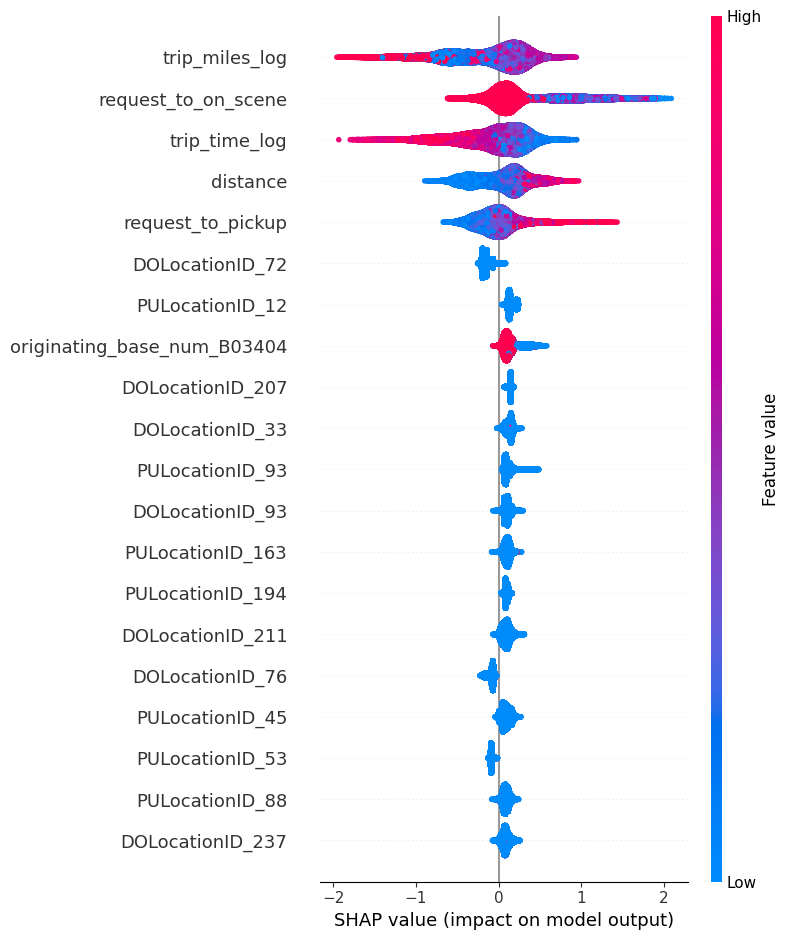

In [ ]:
# Shap analysis
import shap

feature_names = (bf_numeric_features + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(bf_categorical_features).tolist())

X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)

if hasattr(X_test_processed, 'toarray'):
    X_test_processed = X_test_processed.toarray()

X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names)

explainer = shap.TreeExplainer(best_model.named_steps['regressor'])
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed)

SHAP says high trip_miles_log and trip_time_log decreases the base_passenger_fare_logged. <br>
This could be result of log transformations on features and target.<br>
Or due to collinearity of trip_miles and trip_time.<br>

Since variable interpretability is not accurate, SHAP plot cannot be relied on.


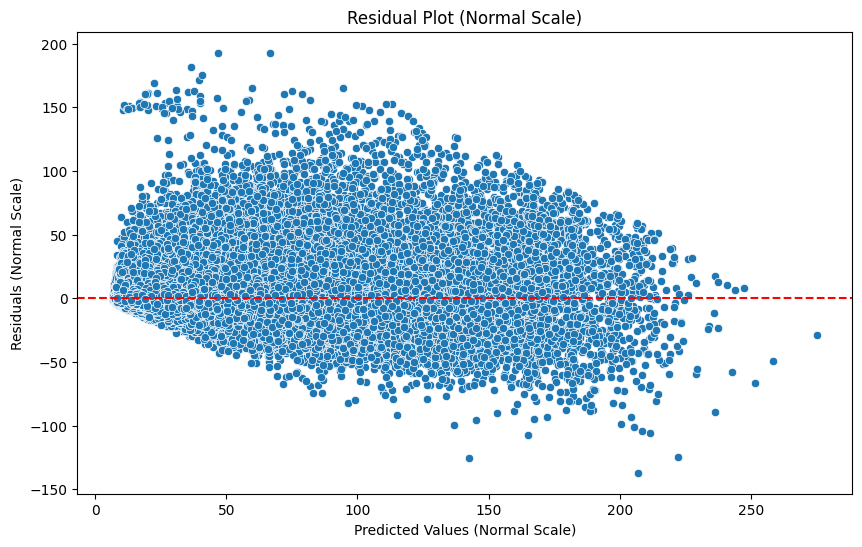

In [87]:
# Residual Analysis
residuals = y_test_normal - y_pred_normal
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_normal, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (Normal Scale)')
plt.ylabel('Residuals (Normal Scale)')
plt.title('Residual Plot (Normal Scale)')
plt.show()

The residuals don't show a clear pattern, which is nice.<br>
Maybe the model is having a hard time capturing higher priced rides.

#### Model Adjustment Check

Since the correlation of trip_mile and trip_time was very strong, model will be adjusted to see if it would be better to modify them.<br>
Create average_speed and produce new model and check the result.

In [95]:
df['average_speed'] = df['trip_miles'] / (df['trip_time'] + 1)  # Add a small constant to avoid division by zero
df['average_speed_log'] = np.log((df['trip_miles'] / (df['trip_time'] + 1))+1)

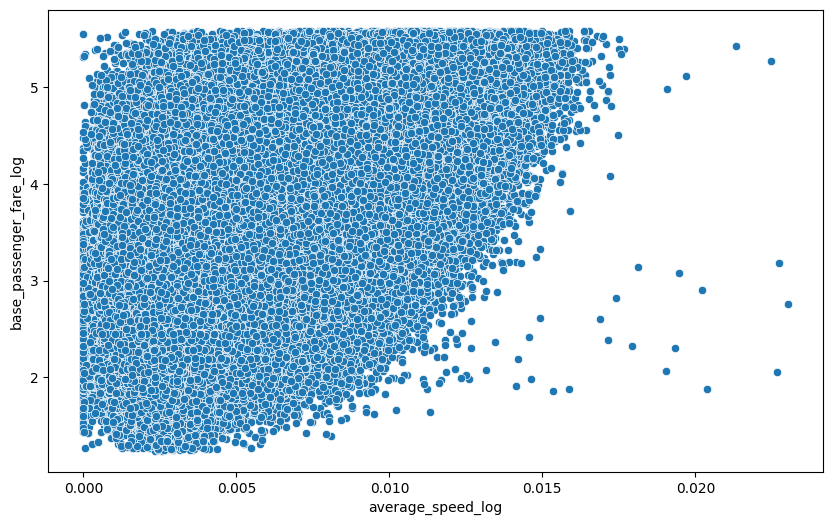

In [96]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['average_speed_log'], y=df['base_passenger_fare_log'])
plt.show()

In [101]:
df[['average_speed_log', 'base_passenger_fare_log']].corr()

,average_speed_log,base_passenger_fare_log
average_speed_log,1.000000,0.506589
base_passenger_fare_log,0.506589,1.000000


In [102]:
bf_numeric_features = [
    'distance',
    'request_to_pickup',
    'request_to_on_scene',
    'average_speed_log'
]

X_vif = df[bf_numeric_features]
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]

print(vif_data)

               feature       VIF
0             distance  2.571147
1    request_to_pickup  2.197788
2  request_to_on_scene  1.248047
3    average_speed_log  3.688798


In [103]:
# features and target
features = bf_categorical_features + bf_binary_features + bf_numeric_features
target = 'base_passenger_fare_log'

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), bf_numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), bf_categorical_features)
    ])

# Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=0))
])

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
y_test_normal = np.exp(y_test)
y_pred_normal = np.exp(y_pred)

# Evaluate on the normal scale
mae_normal = mean_absolute_error(y_test_normal, y_pred_normal)
rmse = np.sqrt(mean_squared_error(y_test_normal, y_pred_normal))
r2 = r2_score(y_test_normal, y_pred_normal)
print(f"MAE (Normal Scale): ${mae_normal:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE (Normal Scale): $6.14
RMSE: $11.78
R²: 0.7156


VIF decreased, but error metrics worsened.<br>
The best model available out of this dataset is best_model.

## Final Model

In [ ]:
# Save the final model
import joblib
joblib.dump(best_model, 'NY_ride_base_fare_prediction.pkl')

In [108]:
df['base_passenger_fare_prediction'] = np.exp(model.predict(df[features]))

In [114]:
df[['base_passenger_fare','base_passenger_fare_prediction']].sample(10)

,base_passenger_fare,base_passenger_fare_prediction
2096757,21.41,24.504021
4617395,19.02,19.514309
2550986,16.44,17.986998
3609132,39.26,43.880585
2958194,8.40,10.045929
4474741,12.51,22.476860
1886888,31.29,26.598438
4695632,55.45,48.045383
4054855,34.13,20.449406
1870206,13.56,21.057426


## Business Insight

Trip distance and time are the most significant drivers of fare prices.<br>
High correlation of trip distance and time makes it harder to access the impact of each feature on fare.<br>

Weather had minimal impact on the price.<br>
Time of the day, months, year had minimal impact on the price.<br>
Increased trip time from traffic due to weather might.

Pickup and dropoff at airports are significantly more expensive.<br>
Pickup at Manhattan is pricier while dropoff at Manhattan is not expensive.<br>
Dropoff outside of NYC is expensive.

Customers from and to airport are not as concerned about expensive ride fares.<br>
Customer from Manhattan, and customers going outside NYC are not as concerned about expensive ride fares.<br>
Prices involving those trips can be increased.


Note: Model was trained from 2% sample of the data.<br>